# Tracking the Growth of COVID-19 Cases in Global 

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
# Now
! date

2020年  4月 11日 土曜日 23:34:39 JST


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

In [3]:
datadir = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv( datadir + 'time_series_covid19_confirmed_global.csv')
#df = pd.read_csv( datadir + 'time_series_covid19_deaths_global.csv')

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases.head()


Total number of cases (in countries with at least 100 cases) as of 4/10/20


4/10/20
Country/Region         
US               496535
Spain            158273
Italy            147577
France           125931
Germany          122171

## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 496535
	Confirmed cases on 4/3/20 	 275586
	Ratio: 1.8
	Weekly increase: 80.2 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9993511650697321
	Doubling Time (during middle of growth):  6.7 (± 0.2 ) days
	param:  [ 3.82130633e+06  2.06874191e-01 -1.13526163e+03  6.33957004e+05]

** Based on Exponential Fit **

	R^2: 0.9842592272963463
	Doubling Time (represents overall growth):  5.91 (± 0.35 ) days
	param:  [  52.04954996    0.1172181  -100.        ]


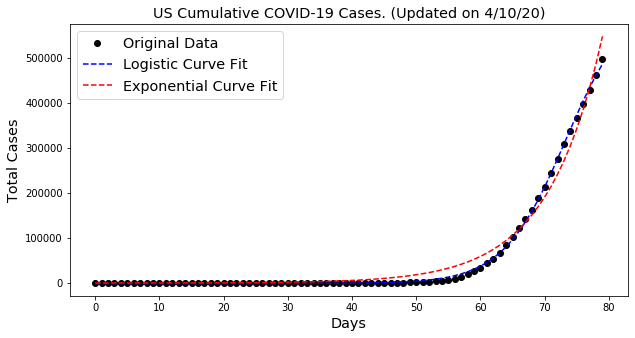



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 158273
	Confirmed cases on 4/3/20 	 119199
	Ratio: 1.33
	Weekly increase: 32.8 %
	Daily increase: 4.1 % per day
	Doubling Time (represents recent growth): 17.1 days

** Based on Logistic Fit**

	R^2: 0.9995634918775286
	Doubling Time (during middle of growth):  6.96 (± 0.17 ) days
	param:  [ 9.70667839e+04  1.99073546e-01 -4.66866624e+02  1.71205581e+05]

 exponential R^2  0.9360702711570604


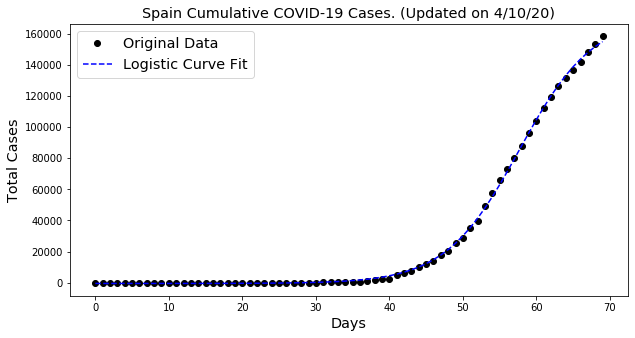



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 147577
	Confirmed cases on 4/3/20 	 119827
	Ratio: 1.23
	Weekly increase: 23.2 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.3 days

** Based on Logistic Fit**

	R^2: 0.9991309169457611
	Doubling Time (during middle of growth):  8.98 (± 0.3 ) days
	param:  [ 4.62376253e+03  1.54374663e-01 -9.48619108e+02  1.56420928e+05]

 exponential R^2  0.8350893959557066


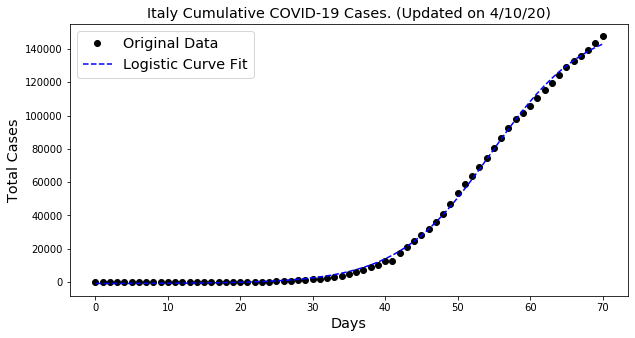



France

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 125931
	Confirmed cases on 4/3/20 	 65202
	Ratio: 1.93
	Weekly increase: 93.1 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9964023333415462
	Doubling Time (during middle of growth):  8.69 (± 0.64 ) days
	param:  [ 1.20436156e+05  1.59613455e-01 -1.51854944e+02  1.99828433e+05]

** Based on Exponential Fit **

	R^2: 0.9876453199978924
	Doubling Time (represents overall growth):  6.68 (± 0.36 ) days
	param:  [  47.6625801     0.10371891 -100.        ]




Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 122171
	Confirmed cases on 4/3/20 	 91159
	Ratio: 1.34
	Weekly increase: 34.0 %
	Daily increase: 4.3 % per day
	Doubling Time (represents recent growth): 16.6 days

** Based on Logistic Fit**

	R^2: 0.9991889619052909
	Doubling Time (during middle of growth):  7.48 (± 0.24 ) days
	param:  [ 1.17833438e+05  1.85340196e-01 -4.23211866e+02  1.34703551e+05]

** Based on Exponential Fit **

	R^2: 0.9577719971473556
	Doubling Time (represents overall growth):  7.01 (± 0.74 ) days
	param:  [1.00000000e+02 9.88234499e-02 1.00000000e+02]


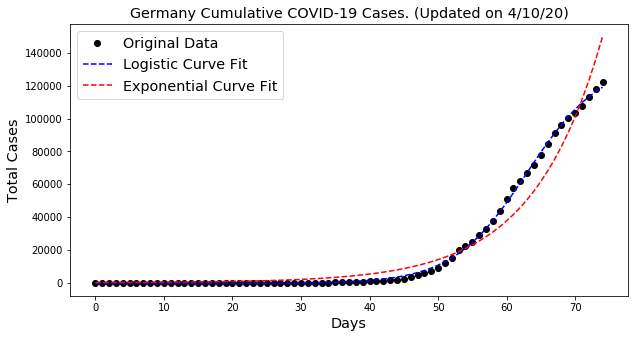



China

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 82941
	Confirmed cases on 4/3/20 	 82511
	Ratio: 1.01
	Weekly increase: 0.5 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 933.5 days

** Based on Logistic Fit**

	R^2: 0.9958413763399409
	Doubling Time (during middle of growth):  6.62 (± 0.45 ) days
	param:  [ 3.98197267e+01  2.09473555e-01 -1.69851641e+03  8.16145040e+04]

 exponential R^2  -2.5776600678519754




United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 74605
	Confirmed cases on 4/3/20 	 38689
	Ratio: 1.93
	Weekly increase: 92.8 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9991870791950622
	Doubling Time (during middle of growth):  7.57 (± 0.27 ) days
	param:  [ 1.89955780e+05  1.83050875e-01 -1.42843365e+02  1.09292350e+05]

** Based on Exponential Fit **

	R^2: 0.9904950643589061
	Doubling Time (represents overall growth):  5.89 (± 0.29 ) days
	param:  [  20.8430141    0.1176967 -100.       ]




Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 68192
	Confirmed cases on 4/3/20 	 53183
	Ratio: 1.28
	Weekly increase: 28.2 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.5 days

** Based on Logistic Fit**

	R^2: 0.9974896180284398
	Doubling Time (during middle of growth):  14.33 (± 1.47 ) days
	param:  [ 7.49703046e+01  9.67191931e-02 -2.07232944e+03  1.08802625e+05]

 exponential R^2  0.7190601080983241




Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 47029
	Confirmed cases on 4/3/20 	 20921
	Ratio: 2.25
	Weekly increase: 124.8 %
	Daily increase: 12.3 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.998327336396962
	Doubling Time (during middle of growth):  6.85 (± 0.66 ) days
	param:  [ 2.63577326e+02  2.02509176e-01 -9.63276823e+02  7.46019785e+04]

 exponential R^2  0.9106216279126055


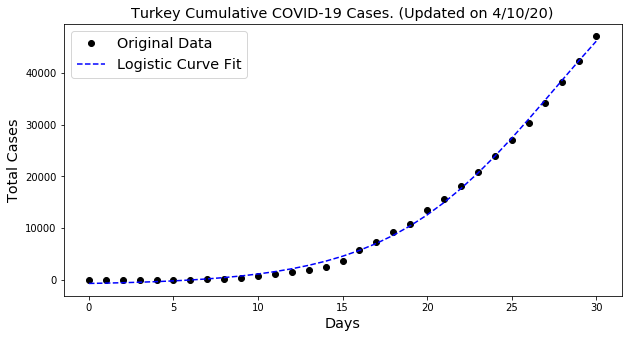



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 26667
	Confirmed cases on 4/3/20 	 16770
	Ratio: 1.59
	Weekly increase: 59.0 %
	Daily increase: 6.9 % per day
	Doubling Time (represents recent growth): 10.5 days

** Based on Logistic Fit**

	R^2: 0.9988625077227357
	Doubling Time (during middle of growth):  7.33 (± 0.31 ) days
	param:  [ 6.06357711e+04  1.89190954e-01 -6.06036253e+01  3.17327989e+04]

** Based on Exponential Fit **

	R^2: 0.9797318535062558
	Doubling Time (represents overall growth):  7.03 (± 0.56 ) days
	param:  [ 4.43879840e+01  9.85609302e-02 -1.00000000e+02]


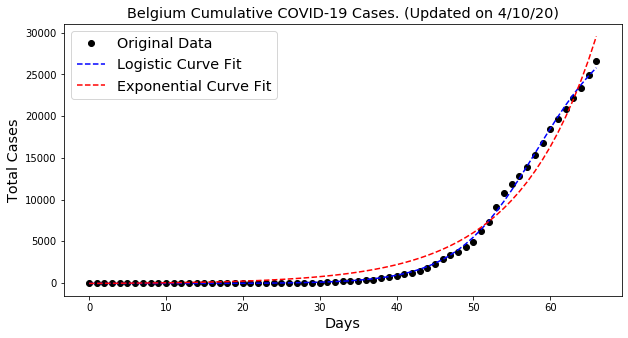



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 24551
	Confirmed cases on 4/3/20 	 19606
	Ratio: 1.25
	Weekly increase: 25.2 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.6 days

** Based on Logistic Fit**

	R^2: 0.9979472260072768
	Doubling Time (during middle of growth):  7.6 (± 0.51 ) days
	param:  [ 2.84166539e+02  1.82420551e-01 -4.10641785e+02  2.56288613e+04]

 exponential R^2  0.767156866443262




Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 23249
	Confirmed cases on 4/3/20 	 15821
	Ratio: 1.47
	Weekly increase: 47.0 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9989792807204038
	Doubling Time (during middle of growth):  8.37 (± 0.45 ) days
	param:  [ 2.70221432e+02  1.65550114e-01 -2.93263995e+02  2.74236468e+04]

 exponential R^2  0.8843412387873189




Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 22059
	Confirmed cases on 4/3/20 	 12437
	Ratio: 1.77
	Weekly increase: 77.4 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.9991318429730021
	Doubling Time (during middle of growth):  6.92 (± 0.24 ) days
	param:  [ 1.08715088e+06  2.00294879e-01 -3.56762225e+01  2.88111981e+04]

** Based on Exponential Fit **

	R^2: 0.9857309541879966
	Doubling Time (represents overall growth):  6.11 (± 0.36 ) days
	param:  [   4.91175683    0.11349015 -100.        ]




Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 19638
	Confirmed cases on 4/3/20 	 9056
	Ratio: 2.17
	Weekly increase: 116.9 %
	Daily increase: 11.7 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9983725393196411
	Doubling Time (during middle of growth):  8.89 (± 0.7 ) days
	param:  [ 1.50569856e+03  1.55872938e-01 -1.83266938e+02  5.10487970e+04]

** Based on Exponential Fit **

	R^2: 0.9954471872683838
	Doubling Time (represents overall growth):  5.45 (± 0.26 ) days
	param:  [  76.55873728    0.12721729 -100.        ]


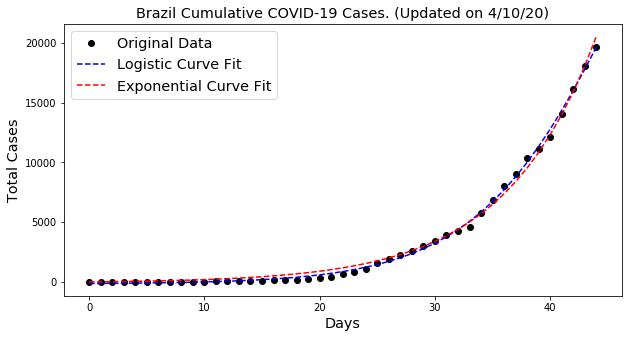



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 15472
	Confirmed cases on 4/3/20 	 9886
	Ratio: 1.57
	Weekly increase: 56.5 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.8 days

** Based on Logistic Fit**

	R^2: 0.9977710314911105
	Doubling Time (during middle of growth):  7.01 (± 0.56 ) days
	param:  [ 4.20088065e+02  1.97804723e-01 -1.95412202e+02  1.72979114e+04]

 exponential R^2  0.926915283754188


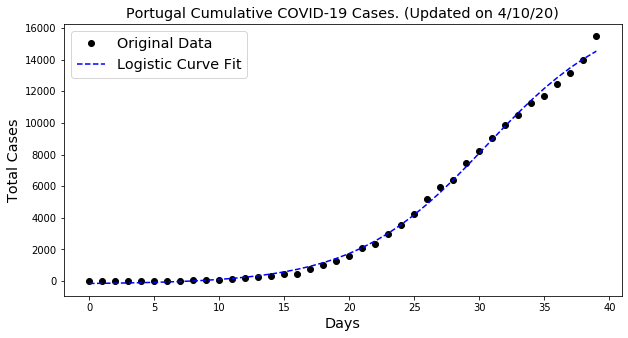



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 13555
	Confirmed cases on 4/3/20 	 11524
	Ratio: 1.18
	Weekly increase: 17.6 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 29.9 days

** Based on Logistic Fit**

	R^2: 0.9991992293105186
	Doubling Time (during middle of growth):  5.92 (± 0.23 ) days
	param:  [ 1.16435703e+03  2.34125947e-01 -7.33581561e+01  1.35162136e+04]

 exponential R^2  0.8124054575485954


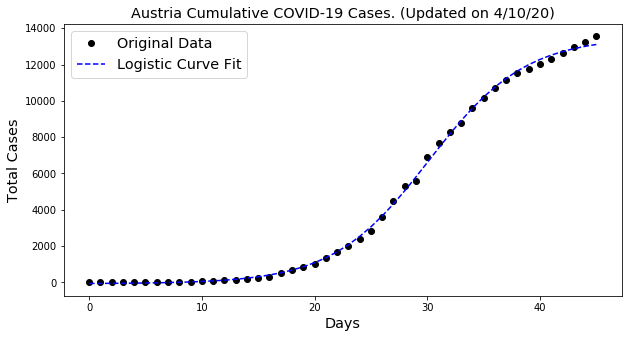



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 11917
	Confirmed cases on 4/3/20 	 4149
	Ratio: 2.87
	Weekly increase: 187.2 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9984715853924466
	Doubling Time (represents overall growth):  4.26 (± 0.08 ) days
	param:  [  0.13629508   0.1627766  -44.33809799]


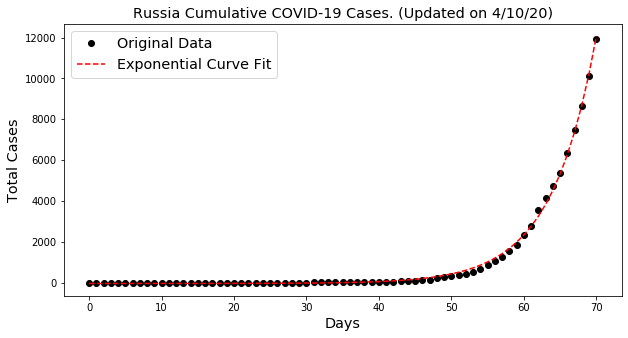



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 10450
	Confirmed cases on 4/3/20 	 10062
	Ratio: 1.04
	Weekly increase: 3.9 %
	Daily increase: 0.5 % per day
	Doubling Time (represents recent growth): 128.2 days

** Based on Logistic Fit**

	R^2: 0.9905003784670691
	Doubling Time (during middle of growth):  6.47 (± 0.69 ) days
	param:  [ 7.06898488e+03  2.14132257e-01 -1.43636660e+02  9.58557301e+03]

 exponential R^2  0.5596038778328968


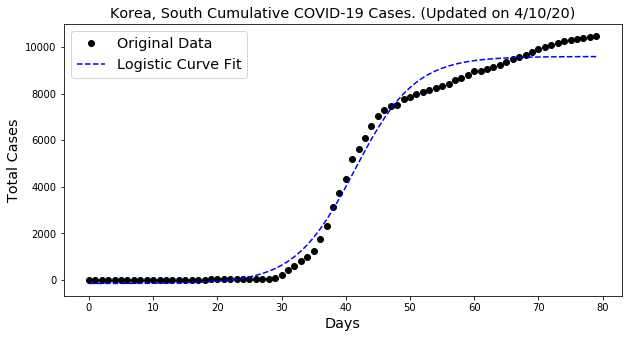



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 10408
	Confirmed cases on 4/3/20 	 7428
	Ratio: 1.4
	Weekly increase: 40.1 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.4 days

** Based on Logistic Fit**

	R^2: 0.998727981745224
	Doubling Time (during middle of growth):  5.6 (± 0.27 ) days
	param:  [ 1.58660783e+04  2.47659100e-01 -1.69402806e+01  1.09829577e+04]

** Based on Exponential Fit **

	R^2: 0.9586648343486384
	Doubling Time (represents overall growth):  7.06 (± 1.05 ) days
	param:  [ 1.00000000e+02  9.81239636e-02 -1.00000000e+02]


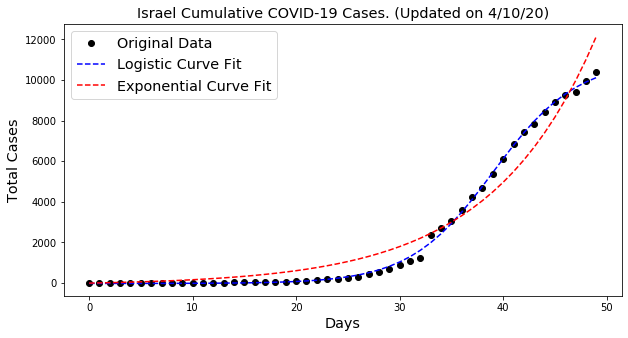



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 9685
	Confirmed cases on 4/3/20 	 6131
	Ratio: 1.58
	Weekly increase: 58.0 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.6 days

** Based on Logistic Fit**

	R^2: 0.9984878974744092
	Doubling Time (during middle of growth):  12.21 (± 0.68 ) days
	param:  [ 3.03414162e+03  1.13552932e-01 -7.20848869e+01  1.99557409e+04]

** Based on Exponential Fit **

	R^2: 0.9949502951336022
	Doubling Time (represents overall growth):  8.17 (± 0.31 ) days
	param:  [ 2.69844315e+01  8.48902645e-02 -1.00000000e+02]


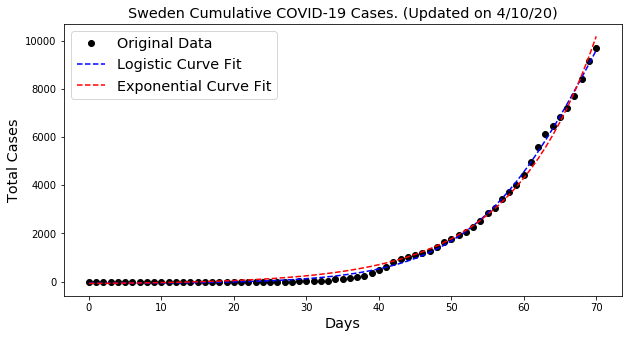



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 8089
	Confirmed cases on 4/3/20 	 4273
	Ratio: 1.89
	Weekly increase: 89.3 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9938079792303038
	Doubling Time (during middle of growth):  10.62 (± 1.87 ) days
	param:  [ 1.96412323e+02  1.30555958e-01 -2.15771688e+02  1.44550518e+04]

** Based on Exponential Fit **

	R^2: 0.9830983828746551
	Doubling Time (represents overall growth):  6.44 (± 0.66 ) days
	param:  [100.           0.10766471 -89.94668212]


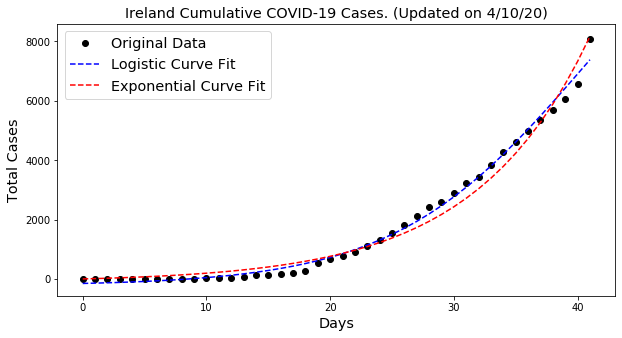



India

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 7598
	Confirmed cases on 4/3/20 	 2567
	Ratio: 2.96
	Weekly increase: 196.0 %
	Daily increase: 16.8 % per day
	Doubling Time (represents recent growth): 4.5 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9961233822177294
	Doubling Time (represents overall growth):  4.51 (± 0.14 ) days
	param:  [  0.14306161   0.15385467 -16.77871114]


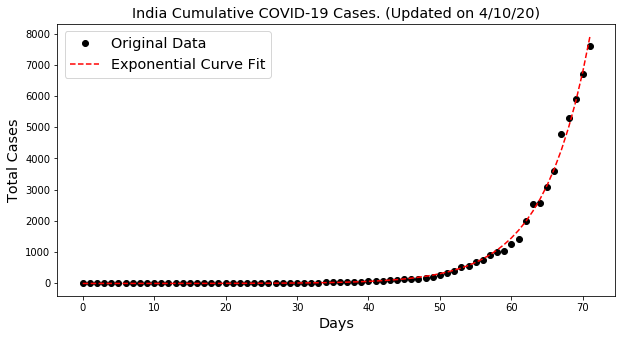



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 7161
	Confirmed cases on 4/3/20 	 3368
	Ratio: 2.13
	Weekly increase: 112.6 %
	Daily increase: 11.4 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9700240899416399
	Doubling Time (during middle of growth):  14.93 (± 9.26 ) days
	param:  [ 1.91833824e+07  9.28488932e-02 -3.33931253e+02  2.99525089e+09]

** Based on Exponential Fit **

	R^2: 0.967042146641061
	Doubling Time (represents overall growth):  6.65 (± 1.02 ) days
	param:  [  97.17634513    0.10429034 -100.        ]




Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 6501
	Confirmed cases on 4/3/20 	 3737
	Ratio: 1.74
	Weekly increase: 74.0 %
	Daily increase: 8.2 % per day
	Doubling Time (represents recent growth): 8.8 days

** Based on Logistic Fit**

	R^2: 0.9988065977297789
	Doubling Time (during middle of growth):  8.01 (± 0.53 ) days
	param:  [ 2.78322163e+02  1.73074562e-01 -1.04887950e+02  8.77577548e+03]

** Based on Exponential Fit **

	R^2: 0.9791397801084786
	Doubling Time (represents overall growth):  6.14 (± 0.74 ) days
	param:  [100.           0.1129428  -81.88061452]


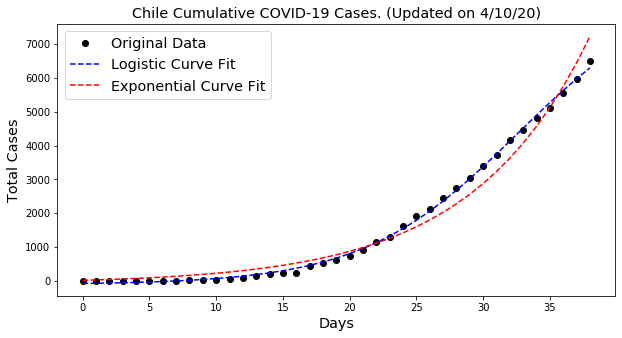



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 6314
	Confirmed cases on 4/3/20 	 5370
	Ratio: 1.18
	Weekly increase: 17.6 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 30.0 days

** Based on Logistic Fit**

	R^2: 0.998663870305031
	Doubling Time (during middle of growth):  9.89 (± 0.62 ) days
	param:  [ 5.98377088e+01  1.40105304e-01 -2.11669177e+02  7.18499409e+03]

 exponential R^2  0.8261189544406341


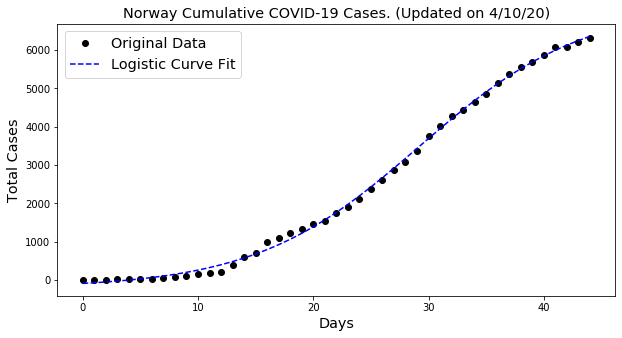



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 6215
	Confirmed cases on 4/3/20 	 5330
	Ratio: 1.17
	Weekly increase: 16.6 %
	Daily increase: 2.2 % per day
	Doubling Time (represents recent growth): 31.6 days

** Based on Logistic Fit**

	R^2: 0.9996819622797021
	Doubling Time (during middle of growth):  5.46 (± 0.11 ) days
	param:  [5.29006215e+06 2.53932156e-01 1.28711750e+01 6.28336801e+03]

 exponential R^2  0.9428051474783108


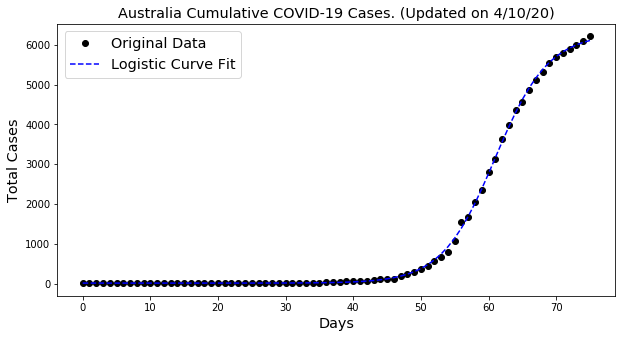



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 6014
	Confirmed cases on 4/3/20 	 3946
	Ratio: 1.52
	Weekly increase: 52.4 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.5 days

** Based on Logistic Fit**

	R^2: 0.9960238064578576
	Doubling Time (during middle of growth):  19.28 (± 5.01 ) days
	param:  [ 1.01398814e+02  7.19061801e-02 -4.86091418e+02  3.71642248e+04]

** Based on Exponential Fit **

	R^2: 0.967938965774547
	Doubling Time (represents overall growth):  7.04 (± 0.98 ) days
	param:  [1.00000000e+02 9.83929257e-02 1.00000000e+02]


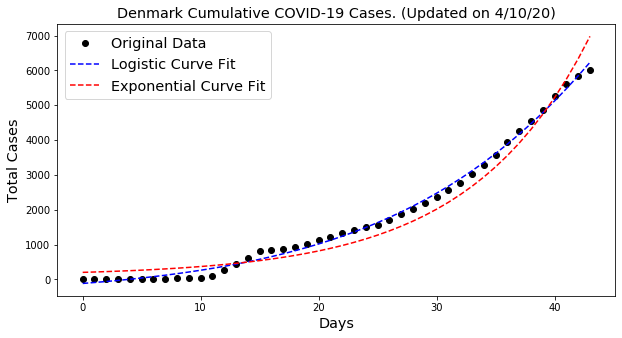



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 5955
	Confirmed cases on 4/3/20 	 3383
	Ratio: 1.76
	Weekly increase: 76.0 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9996466409853537
	Doubling Time (during middle of growth):  8.69 (± 0.35 ) days
	param:  [ 2.21520084e+02  1.59579509e-01 -8.57258684e+01  9.60345615e+03]

** Based on Exponential Fit **

	R^2: 0.9868152131803836
	Doubling Time (represents overall growth):  6.1 (± 0.6 ) days
	param:  [100.           0.11364097 -71.30499126]


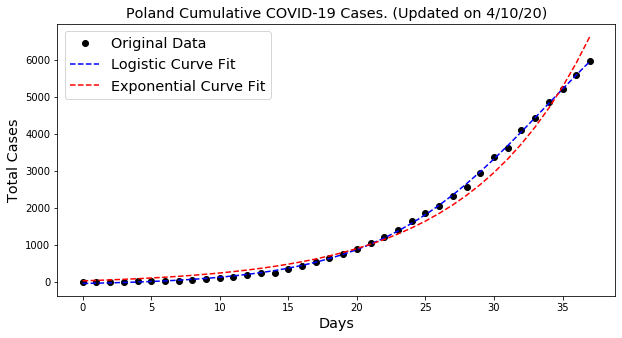



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 5897
	Confirmed cases on 4/3/20 	 1595
	Ratio: 3.7
	Weekly increase: 269.7 %
	Daily increase: 20.5 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9899408867311887
	Doubling Time (during middle of growth):  7.37 (± 0.58 ) days
	param:  [3.17114014e+10 1.87983953e-01 8.18947836e+01 2.57801857e+11]

** Based on Exponential Fit **

	R^2: 0.9899408869297475
	Doubling Time (represents overall growth):  3.69 (± 0.28 ) days
	param:  [ 8.12975355  0.18798349 81.893167  ]


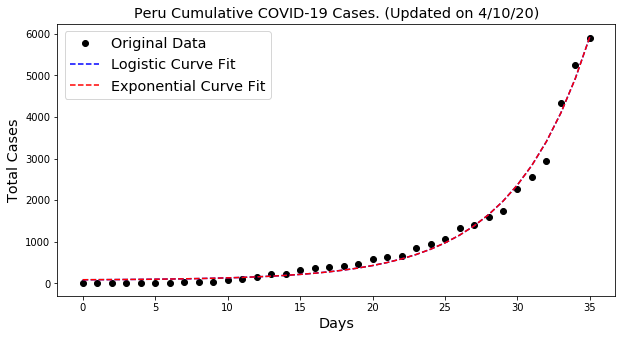



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 5732
	Confirmed cases on 4/3/20 	 4091
	Ratio: 1.4
	Weekly increase: 40.1 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.4 days

** Based on Logistic Fit**

	R^2: 0.9988760287130711
	Doubling Time (during middle of growth):  8.01 (± 0.47 ) days
	param:  [ 1.75843525e+02  1.73105918e-01 -1.01398298e+02  6.62955738e+03]

 exponential R^2  0.9386483962336022




Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 5530
	Confirmed cases on 4/3/20 	 2617
	Ratio: 2.11
	Weekly increase: 111.3 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9917509163741477
	Doubling Time (during middle of growth):  16.44 (± 0.86 ) days
	param:  [2.68301816e+10 8.43448588e-02 5.05308399e+01 1.71944362e+11]

** Based on Exponential Fit **

	R^2: 0.9917509167348917
	Doubling Time (represents overall growth):  8.22 (± 0.37 ) days
	param:  [ 6.40863616  0.08434482 50.53060248]


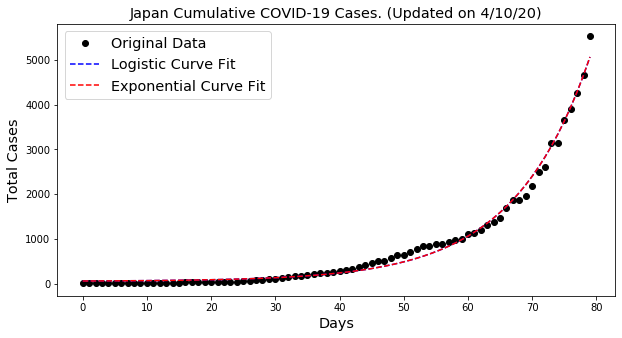



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 5467
	Confirmed cases on 4/3/20 	 3183
	Ratio: 1.72
	Weekly increase: 71.8 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9988035731308459
	Doubling Time (during middle of growth):  7.47 (± 0.43 ) days
	param:  [ 1.24190559e+03  1.85598155e-01 -2.99755639e+01  7.30894169e+03]

** Based on Exponential Fit **

	R^2: 0.985917052391424
	Doubling Time (represents overall growth):  6.64 (± 0.6 ) days
	param:  [  61.63087847    0.10440129 -100.        ]


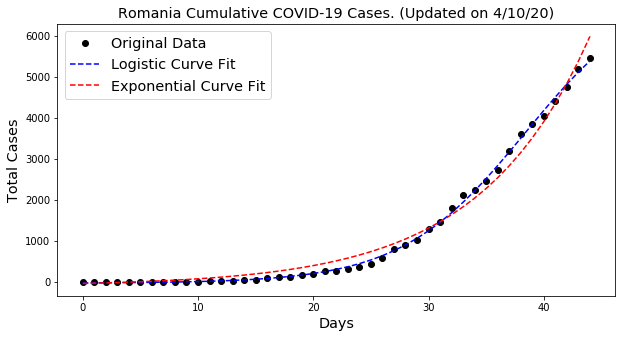



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 4695
	Confirmed cases on 4/3/20 	 2686
	Ratio: 1.75
	Weekly increase: 74.8 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9957584198340544
	Doubling Time (during middle of growth):  10.53 (± 1.41 ) days
	param:  [ 3.09444476e+02  1.31597081e-01 -1.01014828e+02  9.44490786e+03]

** Based on Exponential Fit **

	R^2: 0.9900393545328783
	Doubling Time (represents overall growth):  7.18 (± 0.56 ) days
	param:  [ 7.46649235e+01  9.65365231e-02 -1.00000000e+02]




Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 4346
	Confirmed cases on 4/3/20 	 3333
	Ratio: 1.3
	Weekly increase: 30.4 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.3 days

** Based on Logistic Fit**

	R^2: 0.9978908923157316
	Doubling Time (during middle of growth):  8.71 (± 0.45 ) days
	param:  [ 2.49698572e+04  1.59097625e-01 -1.24120474e+01  4.84124240e+03]

** Based on Exponential Fit **

	R^2: 0.9725433920712957
	Doubling Time (represents overall growth):  9.88 (± 0.89 ) days
	param:  [ 2.47087107e+01  7.01220472e-02 -1.00000000e+02]


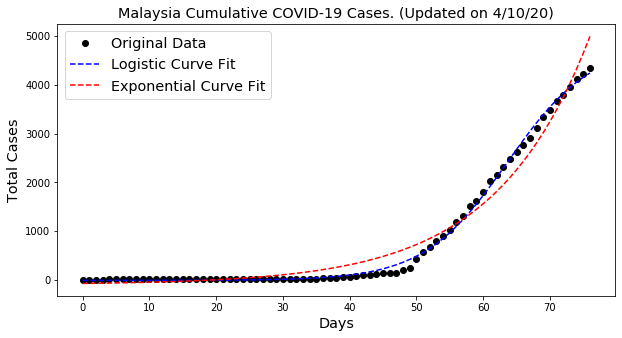



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 4195
	Confirmed cases on 4/3/20 	 3018
	Ratio: 1.39
	Weekly increase: 39.0 %
	Daily increase: 4.8 % per day
	Doubling Time (represents recent growth): 14.7 days

** Based on Logistic Fit**

	R^2: 0.9981843221541562
	Doubling Time (during middle of growth):  5.27 (± 0.26 ) days
	param:  [1.23808316e+07 2.63085458e-01 1.49013163e+01 4.57184482e+03]

** Based on Exponential Fit **

	R^2: 0.9690934684064004
	Doubling Time (represents overall growth):  6.89 (± 0.62 ) days
	param:  [  3.93450795   0.10063964 -92.79181266]




Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 3651
	Confirmed cases on 4/3/20 	 2039
	Ratio: 1.79
	Weekly increase: 79.1 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.99613973691845
	Doubling Time (during middle of growth):  11.36 (± 1.77 ) days
	param:  [ 1.08228946e+02  1.22073425e-01 -1.36023701e+02  6.84420600e+03]

** Based on Exponential Fit **

	R^2: 0.9885349157917377
	Doubling Time (represents overall growth):  7.39 (± 0.71 ) days
	param:  [ 1.00000000e+02  9.38012411e-02 -1.00000000e+02]


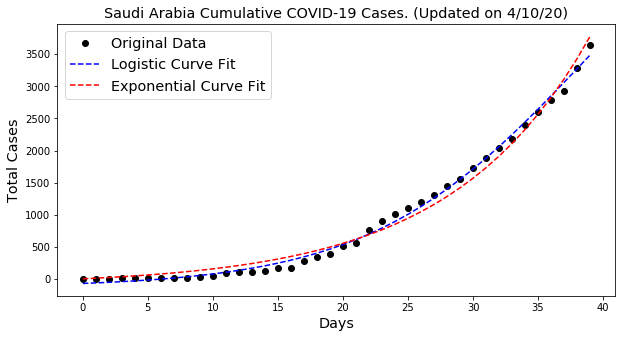



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 3512
	Confirmed cases on 4/3/20 	 1986
	Ratio: 1.77
	Weekly increase: 76.8 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.9976747030994728
	Doubling Time (during middle of growth):  11.97 (± 1.55 ) days
	param:  [ 1.13072388e+02  1.15798289e-01 -1.37640661e+02  7.88065119e+03]

** Based on Exponential Fit **

	R^2: 0.992259304635463
	Doubling Time (represents overall growth):  7.44 (± 0.59 ) days
	param:  [ 1.00000000e+02  9.31025471e-02 -1.00000000e+02]


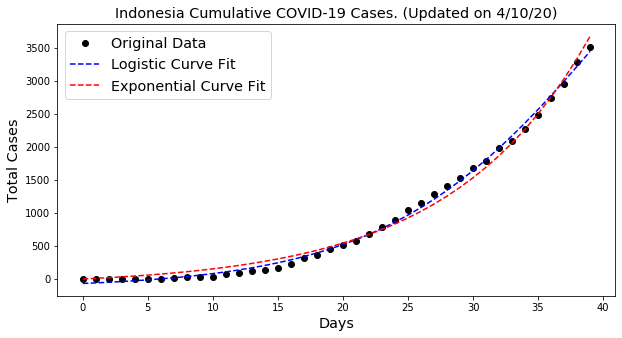



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 3441
	Confirmed cases on 4/3/20 	 1510
	Ratio: 2.28
	Weekly increase: 127.9 %
	Daily increase: 12.5 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9983069736287586
	Doubling Time (during middle of growth):  9.72 (± 0.88 ) days
	param:  [ 9.98058177e+02  1.42669480e-01 -4.50369514e+01  1.21551597e+04]

** Based on Exponential Fit **

	R^2: 0.9975810982951566
	Doubling Time (represents overall growth):  5.85 (± 0.21 ) days
	param:  [ 24.90562379   0.1184807  -81.62602186]




United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 3360
	Confirmed cases on 4/3/20 	 1264
	Ratio: 2.66
	Weekly increase: 165.8 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.996501238259318
	Doubling Time (represents overall growth):  4.63 (± 0.13 ) days
	param:  [0.07385594 0.14956038 5.40657253]


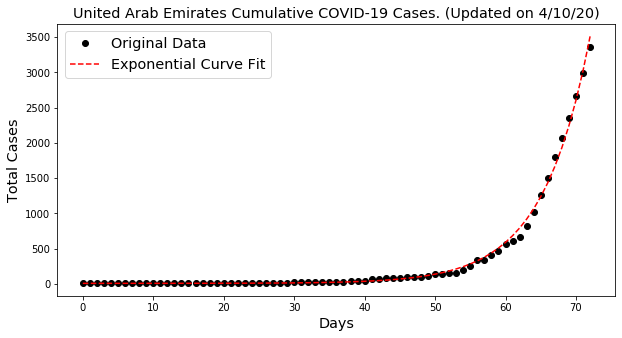



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 3223
	Confirmed cases on 4/3/20 	 2612
	Ratio: 1.23
	Weekly increase: 23.4 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.1 days

** Based on Logistic Fit**

	R^2: 0.996971557289029
	Doubling Time (during middle of growth):  6.25 (± 0.51 ) days
	param:  [ 4.10919086e+02  2.21774457e-01 -6.34095600e+01  3.23955827e+03]

 exponential R^2  0.9119104019003637


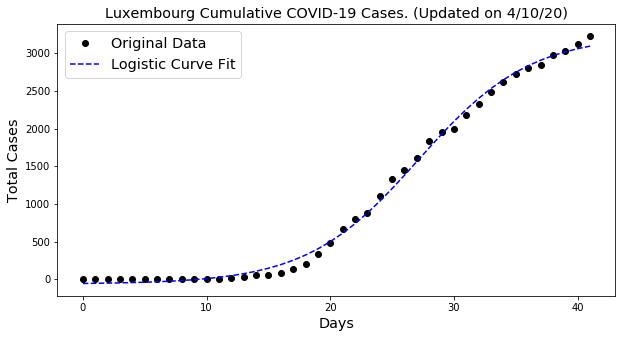



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 3105
	Confirmed cases on 4/3/20 	 1476
	Ratio: 2.1
	Weekly increase: 110.4 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9986193003330931
	Doubling Time (during middle of growth):  7.36 (± 0.58 ) days
	param:  [ 5.20692135e+02  1.88271130e-01 -6.64476980e+00  5.39530637e+03]

** Based on Exponential Fit **

	R^2: 0.9940747804878981
	Doubling Time (represents overall growth):  5.85 (± 0.4 ) days
	param:  [  54.01343867    0.11851506 -100.        ]


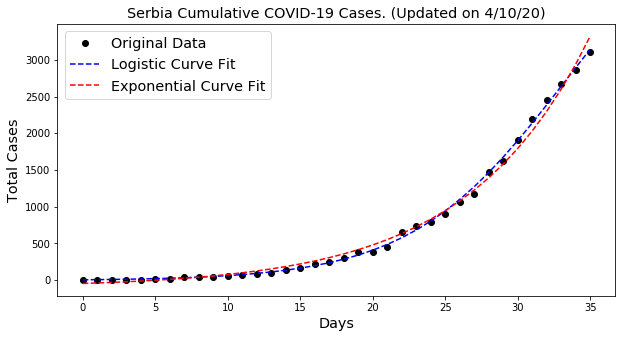



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2769
	Confirmed cases on 4/3/20 	 1615
	Ratio: 1.71
	Weekly increase: 71.5 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9955265203999747
	Doubling Time (during middle of growth):  11.21 (± 0.98 ) days
	param:  [ 4.36029351e+03  1.23697057e-01 -2.62128243e+01  4.30829515e+03]

** Based on Exponential Fit **

	R^2: 0.9892092449539339
	Doubling Time (represents overall growth):  8.87 (± 0.49 ) days
	param:  [ 10.78971865   0.07818327 -77.57512106]


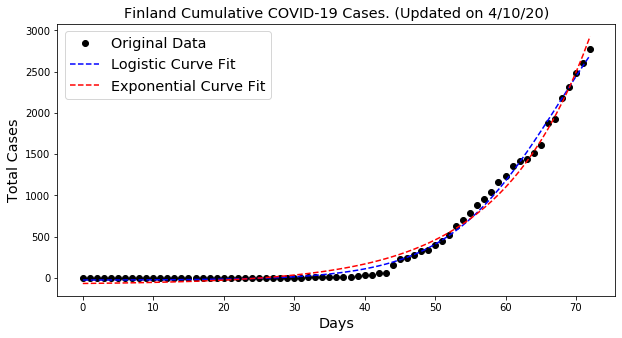



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2752
	Confirmed cases on 4/3/20 	 1475
	Ratio: 1.87
	Weekly increase: 86.6 %
	Daily increase: 9.3 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9974130560982482
	Doubling Time (during middle of growth):  10.01 (± 1.57 ) days
	param:  [ 5.89172138e+01  1.38533311e-01 -1.24832075e+02  4.93660202e+03]

** Based on Exponential Fit **

	R^2: 0.9834815226945727
	Doubling Time (represents overall growth):  6.31 (± 0.85 ) days
	param:  [100.           0.10985685 -53.73976498]




Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2620
	Confirmed cases on 4/3/20 	 1488
	Ratio: 1.76
	Weekly increase: 76.1 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9939331657030539
	Doubling Time (during middle of growth):  7.37 (± 1.01 ) days
	param:  [ 5.76055027e+02  1.88113740e-01 -4.29607054e+01  3.21535121e+03]

** Based on Exponential Fit **

	R^2: 0.9812009603466135
	Doubling Time (represents overall growth):  6.88 (± 0.8 ) days
	param:  [  50.48018479    0.10072211 -100.        ]


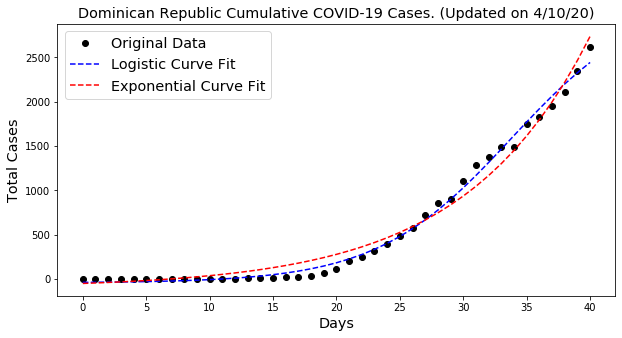



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2512
	Confirmed cases on 4/3/20 	 1075
	Ratio: 2.34
	Weekly increase: 133.7 %
	Daily increase: 12.9 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9664528920771763
	Doubling Time (during middle of growth):  12.67 (± 3.64 ) days
	param:  [1.92090977e+09 1.09442405e-01 6.86201557e+01 5.47482857e+10]

** Based on Exponential Fit **

	R^2: 0.9664528924866422
	Doubling Time (represents overall growth):  6.33 (± 0.91 ) days
	param:  [28.50087102  0.10944272 68.62145661]




Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2473
	Confirmed cases on 4/3/20 	 1267
	Ratio: 1.95
	Weekly increase: 95.2 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9970197595273947
	Doubling Time (during middle of growth):  11.17 (± 1.83 ) days
	param:  [ 1.33382170e+02  1.24136676e-01 -9.58029722e+01  6.76054250e+03]

** Based on Exponential Fit **

	R^2: 0.9948456010564142
	Doubling Time (represents overall growth):  6.88 (± 0.48 ) days
	param:  [  76.92104471    0.10074188 -100.        ]


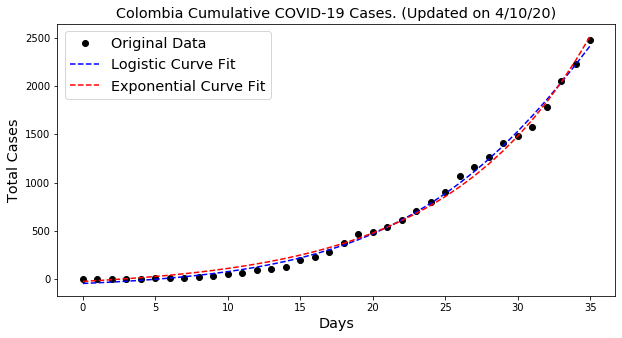



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2473
	Confirmed cases on 4/3/20 	 1978
	Ratio: 1.25
	Weekly increase: 25.0 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 21.7 days

** Based on Logistic Fit**

	R^2: 0.9985913081781219
	Doubling Time (during middle of growth):  6.36 (± 0.26 ) days
	param:  [1.86731335e+06 2.18113586e-01 2.07315594e+01 2.56488654e+03]

** Based on Exponential Fit **

	R^2: 0.9598162784698231
	Doubling Time (represents overall growth):  9.27 (± 0.95 ) days
	param:  [  8.11908543   0.07479662 -66.0027039 ]




Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2203
	Confirmed cases on 4/3/20 	 1072
	Ratio: 2.06
	Weekly increase: 105.5 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.9927396194848698
	Doubling Time (during middle of growth):  6.85 (± 1.09 ) days
	param:  [ 1.09601936e+03  2.02367630e-01 -2.73085541e+01  3.09616342e+03]

** Based on Exponential Fit **

	R^2: 0.9861172144575796
	Doubling Time (represents overall growth):  5.87 (± 0.56 ) days
	param:  [ 26.0088224    0.11811227 -93.82569335]




Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2108
	Confirmed cases on 4/3/20 	 1114
	Ratio: 1.89
	Weekly increase: 89.2 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9946656644227323
	Doubling Time (during middle of growth):  17.45 (± 1.14 ) days
	param:  [4.51985487e+09 7.94478902e-02 1.87231378e+01 1.81660166e+10]

** Based on Exponential Fit **

	R^2: 0.9946656645896158
	Doubling Time (represents overall growth):  8.72 (± 0.32 ) days
	param:  [ 4.01916011  0.07944789 18.72313845]


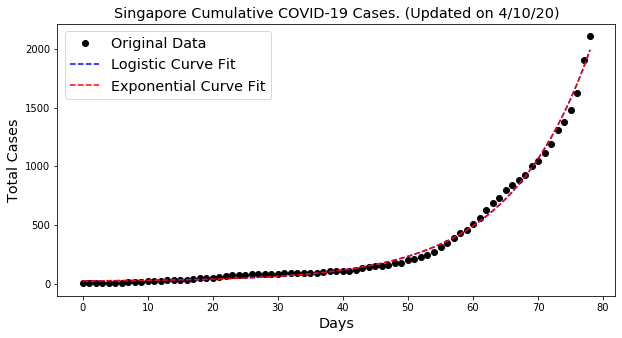



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2011
	Confirmed cases on 4/3/20 	 1613
	Ratio: 1.25
	Weekly increase: 24.7 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 22.0 days

** Based on Logistic Fit**

	R^2: 0.9985328081178285
	Doubling Time (during middle of growth):  10.09 (± 0.69 ) days
	param:  [ 8.45287583e+01  1.37404772e-01 -4.81355288e+01  2.41875293e+03]

** Based on Exponential Fit **

	R^2: 0.9630194074167711
	Doubling Time (represents overall growth):  9.55 (± 1.7 ) days
	param:  [ 1.00000000e+02  7.25705161e-02 -5.89129972e+01]




South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 2003
	Confirmed cases on 4/3/20 	 1505
	Ratio: 1.33
	Weekly increase: 33.1 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 17.0 days

** Based on Logistic Fit**

	R^2: 0.9885559421769492
	Doubling Time (during middle of growth):  5.09 (± 0.85 ) days
	param:  [ 3.63291847e+02  2.72380869e-01 -2.95030390e+01  1.85285618e+03]

 exponential R^2  0.8933547240780975




Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1981
	Confirmed cases on 4/3/20 	 351
	Ratio: 5.64
	Weekly increase: 464.4 %
	Daily increase: 28.0 % per day
	Doubling Time (represents recent growth): 2.8 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9954919219030725
	Doubling Time (represents overall growth):  2.63 (± 0.11 ) days
	param:  [ 0.03004765  0.26328293 26.6449389 ]


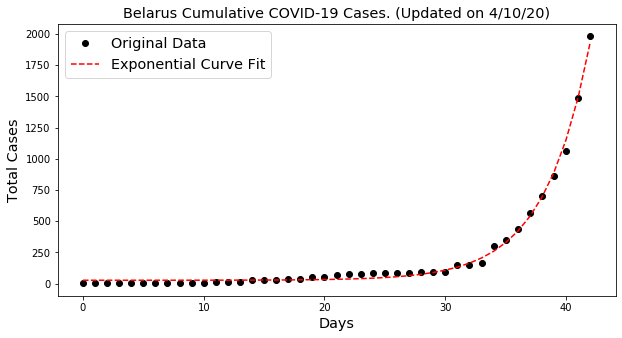



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1975
	Confirmed cases on 4/3/20 	 1265
	Ratio: 1.56
	Weekly increase: 56.1 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.9 days

** Based on Logistic Fit**

	R^2: 0.9971848048536668
	Doubling Time (during middle of growth):  7.18 (± 0.67 ) days
	param:  [ 2.92116286e+02  1.92992185e-01 -2.25326267e+01  2.24430017e+03]

** Based on Exponential Fit **

	R^2: 0.9763945235866829
	Doubling Time (represents overall growth):  7.96 (± 1.2 ) days
	param:  [ 8.21703639e+01  8.70959437e-02 -1.00000000e+02]


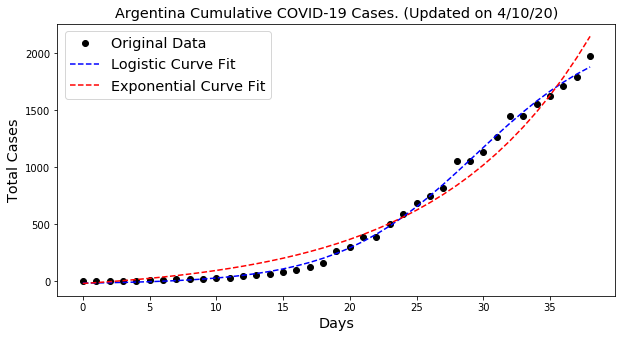



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1794
	Confirmed cases on 4/3/20 	 985
	Ratio: 1.82
	Weekly increase: 82.1 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9977634546056363
	Doubling Time (during middle of growth):  13.96 (± 1.33 ) days
	param:  [ 1.12063192e+03  9.92967976e-02 -2.94118659e+01  9.81028738e+03]

** Based on Exponential Fit **

	R^2: 0.9974869683434955
	Doubling Time (represents overall growth):  7.85 (± 0.25 ) days
	param:  [ 13.49793771   0.08827324 -42.17815379]




Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1761
	Confirmed cases on 4/3/20 	 1171
	Ratio: 1.5
	Weekly increase: 50.4 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 11.9 days

** Based on Logistic Fit**

	R^2: 0.9978972290055437
	Doubling Time (during middle of growth):  6.38 (± 0.45 ) days
	param:  [3.58819778e+03 2.17123181e-01 7.44912305e+00 2.10064512e+03]

** Based on Exponential Fit **

	R^2: 0.9808199377268837
	Doubling Time (represents overall growth):  7.35 (± 0.78 ) days
	param:  [ 29.31168459   0.09425381 -88.27695475]


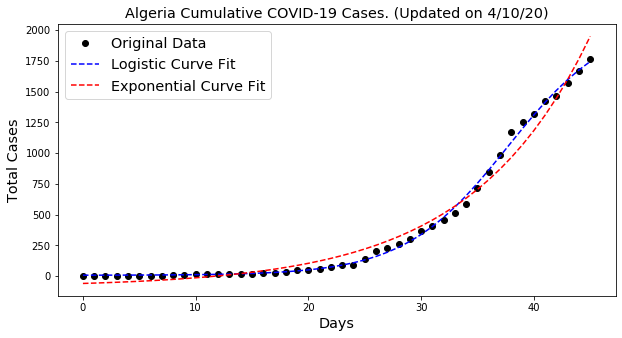



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1675
	Confirmed cases on 4/3/20 	 1364
	Ratio: 1.23
	Weekly increase: 22.8 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.6 days

** Based on Logistic Fit**

	R^2: 0.9989574209467119
	Doubling Time (during middle of growth):  8.37 (± 0.44 ) days
	param:  [ 1.14596216e+02  1.65636364e-01 -2.14811418e+01  1.86115135e+03]

** Based on Exponential Fit **

	R^2: 0.9511909374805895
	Doubling Time (represents overall growth):  9.56 (± 2.08 ) days
	param:  [ 1.00000000e+02  7.24713475e-02 -5.80091814e+01]


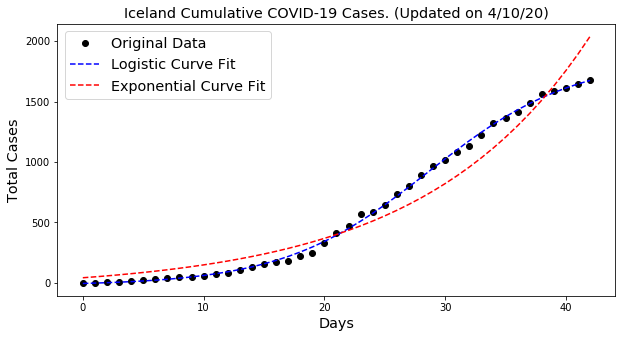



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1495
	Confirmed cases on 4/3/20 	 1079
	Ratio: 1.39
	Weekly increase: 38.6 %
	Daily increase: 4.8 % per day
	Doubling Time (represents recent growth): 14.9 days

** Based on Logistic Fit**

	R^2: 0.997794363924751
	Doubling Time (during middle of growth):  6.78 (± 0.47 ) days
	param:  [ 1.01108799e+03  2.04421708e-01 -9.75194226e+00  1.56131268e+03]

** Based on Exponential Fit **

	R^2: 0.9692776284389335
	Doubling Time (represents overall growth):  9.19 (± 1.42 ) days
	param:  [ 5.92172518e+01  7.54609202e-02 -1.00000000e+02]




Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1448
	Confirmed cases on 4/3/20 	 791
	Ratio: 1.83
	Weekly increase: 83.1 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9983651813833466
	Doubling Time (during middle of growth):  7.52 (± 0.56 ) days
	param:  [ 4.84954635e+02  1.84237273e-01 -1.59868400e+01  1.97183920e+03]

** Based on Exponential Fit **

	R^2: 0.9887956946959657
	Doubling Time (represents overall growth):  7.45 (± 0.7 ) days
	param:  [ 4.41926731e+01  9.30216919e-02 -1.00000000e+02]




Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1438
	Confirmed cases on 4/3/20 	 591
	Ratio: 2.43
	Weekly increase: 143.3 %
	Daily increase: 13.5 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9981772955742847
	Doubling Time (during middle of growth):  6.87 (± 0.64 ) days
	param:  [5.79882410e+02 2.01724484e-01 4.85374149e+00 2.49744371e+03]

** Based on Exponential Fit **

	R^2: 0.9943071978965414
	Doubling Time (represents overall growth):  5.53 (± 0.38 ) days
	param:  [ 24.71656062   0.12541387 -46.52607797]


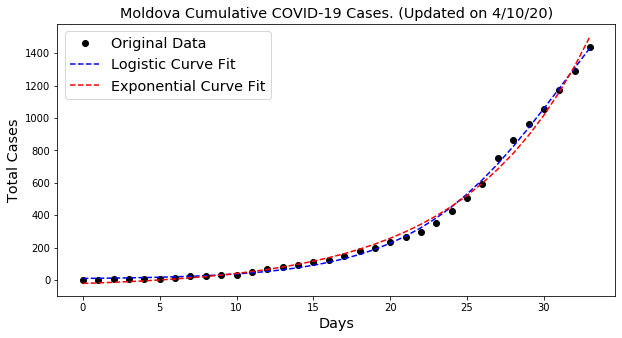



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1283
	Confirmed cases on 4/3/20 	 868
	Ratio: 1.48
	Weekly increase: 47.8 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.4 days

** Based on Logistic Fit**

	R^2: 0.9980923772664737
	Doubling Time (during middle of growth):  5.54 (± 0.36 ) days
	param:  [ 3.40521061e+03  2.50279482e-01 -8.75224054e+00  1.38469764e+03]

** Based on Exponential Fit **

	R^2: 0.9664870035201437
	Doubling Time (represents overall growth):  7.92 (± 1.25 ) days
	param:  [ 4.00767829e+01  8.75229559e-02 -1.00000000e+02]


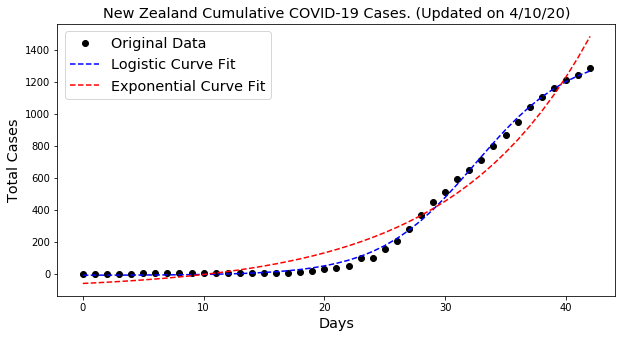



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1279
	Confirmed cases on 4/3/20 	 820
	Ratio: 1.56
	Weekly increase: 56.0 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.9 days

** Based on Logistic Fit**

	R^2: 0.9986234192584705
	Doubling Time (during middle of growth):  10.37 (± 0.71 ) days
	param:  [2.49982814e+02 1.33722075e-01 3.43949524e+00 1.98199480e+03]

** Based on Exponential Fit **

	R^2: 0.9932646878566986
	Doubling Time (represents overall growth):  9.49 (± 0.66 ) days
	param:  [ 5.04537219e+01  7.30529464e-02 -7.59041832e+01]




Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1258
	Confirmed cases on 4/3/20 	 961
	Ratio: 1.31
	Weekly increase: 30.9 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.0 days

** Based on Logistic Fit**

	R^2: 0.9946095957750254
	Doubling Time (during middle of growth):  10.48 (± 1.48 ) days
	param:  [ 8.25309698e+01  1.32267054e-01 -4.12802540e+01  1.63671601e+03]

** Based on Exponential Fit **

	R^2: 0.9776696822183027
	Doubling Time (represents overall growth):  10.66 (± 1.64 ) days
	param:  [ 9.29826352e+01  6.50205138e-02 -1.00000000e+02]




Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1190
	Confirmed cases on 4/3/20 	 623
	Ratio: 1.91
	Weekly increase: 91.0 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9922480706791934
	Doubling Time (during middle of growth):  11.46 (± 2.8 ) days
	param:  [ 1.01698636e+02  1.20952485e-01 -4.35182118e+01  2.39519343e+03]

** Based on Exponential Fit **

	R^2: 0.9907927369555316
	Doubling Time (represents overall growth):  8.5 (± 0.83 ) days
	param:  [ 5.98129636e+01  8.15510187e-02 -9.53567854e+01]




Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 1160
	Confirmed cases on 4/3/20 	 934
	Ratio: 1.24
	Weekly increase: 24.2 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.4 days

** Based on Logistic Fit**

	R^2: 0.9977668654863329
	Doubling Time (during middle of growth):  13.16 (± 1.93 ) days
	param:  [ 1.10861132e+01  1.05307706e-01 -1.54439914e+02  1.48497086e+03]

 exponential R^2  0.9315783066500677


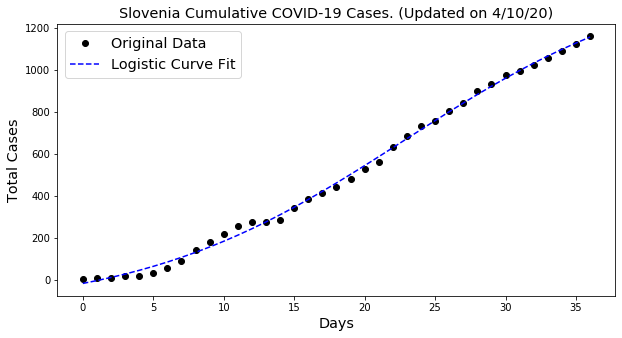



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 999
	Confirmed cases on 4/3/20 	 696
	Ratio: 1.44
	Weekly increase: 43.5 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.4 days

** Based on Logistic Fit**

	R^2: 0.9973587934798769
	Doubling Time (during middle of growth):  6.58 (± 0.52 ) days
	param:  [ 8.06311835e+02  2.10758458e-01 -1.35253209e+01  1.08416944e+03]

** Based on Exponential Fit **

	R^2: 0.9713479713179128
	Doubling Time (represents overall growth):  9.16 (± 1.46 ) days
	param:  [ 5.09452842e+01  7.57033017e-02 -1.00000000e+02]


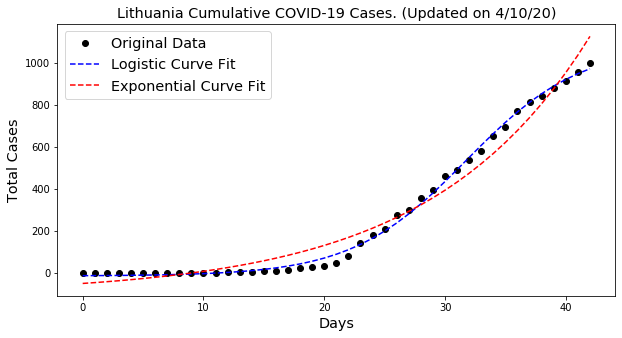



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 993
	Confirmed cases on 4/3/20 	 417
	Ratio: 2.38
	Weekly increase: 138.1 %
	Daily increase: 13.2 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.9872935591850299
	Doubling Time (during middle of growth):  11.07 (± 0.79 ) days
	param:  [1.17707554e+10 1.25194346e-01 5.19497506e+01 3.57545282e+10]

** Based on Exponential Fit **

	R^2: 0.9872935593665509
	Doubling Time (represents overall growth):  5.54 (± 0.42 ) days
	param:  [ 3.03758742  0.12519424 51.94964332]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt





Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 991
	Confirmed cases on 4/3/20 	 443
	Ratio: 2.24
	Weekly increase: 123.7 %
	Daily increase: 12.2 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9990148315935279
	Doubling Time (during middle of growth):  7.84 (± 0.48 ) days
	param:  [ 1.14340128e+03  1.76793490e-01 -6.63767555e-03  1.95639373e+03]

** Based on Exponential Fit **

	R^2: 0.9959235290761403
	Doubling Time (represents overall growth):  5.69 (± 0.28 ) days
	param:  [  8.15691142   0.12171352 -21.15846622]




Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 937
	Confirmed cases on 4/3/20 	 736
	Ratio: 1.27
	Weekly increase: 27.3 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.1 days

** Based on Logistic Fit**

	R^2: 0.9972123482383403
	Doubling Time (during middle of growth):  7.56 (± 0.67 ) days
	param:  [ 2.38504449e+02  1.83384847e-01 -1.33469426e+01  1.09971226e+03]

** Based on Exponential Fit **

	R^2: 0.9750971585899265
	Doubling Time (represents overall growth):  9.84 (± 1.63 ) days
	param:  [ 7.04850024e+01  7.04612066e-02 -1.00000000e+02]


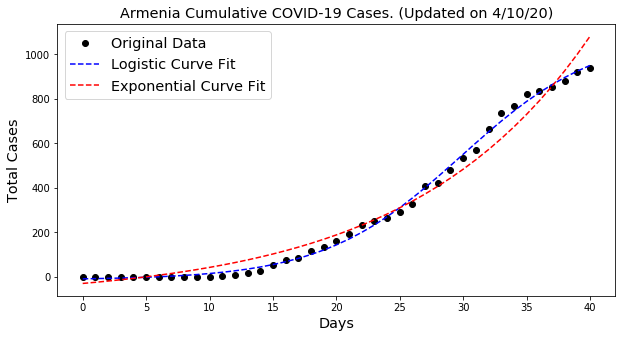



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 925
	Confirmed cases on 4/3/20 	 672
	Ratio: 1.38
	Weekly increase: 37.6 %
	Daily increase: 4.7 % per day
	Doubling Time (represents recent growth): 15.2 days

** Based on Logistic Fit**

	R^2: 0.9957422205190843
	Doubling Time (during middle of growth):  25.28 (± 8.66 ) days
	param:  [ 2.92892329e+01  5.48381522e-02 -1.12513550e+02  3.32603412e+03]

** Based on Exponential Fit **

	R^2: 0.9918260937264285
	Doubling Time (represents overall growth):  13.65 (± 1.36 ) days
	param:  [ 1.00000000e+02  5.07883892e-02 -7.57472503e+01]


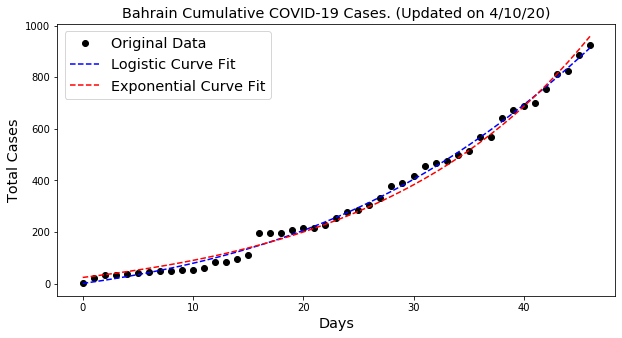



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 901
	Confirmed cases on 4/3/20 	 579
	Ratio: 1.56
	Weekly increase: 55.6 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.0 days

** Based on Logistic Fit**

	R^2: 0.9982877432153551
	Doubling Time (during middle of growth):  7.82 (± 0.64 ) days
	param:  [ 1.78916691e+02  1.77357113e-01 -1.08864247e+01  1.16113136e+03]

** Based on Exponential Fit **

	R^2: 0.98854742223433
	Doubling Time (represents overall growth):  8.86 (± 1.03 ) days
	param:  [ 6.37897066e+01  7.82671903e-02 -1.00000000e+02]


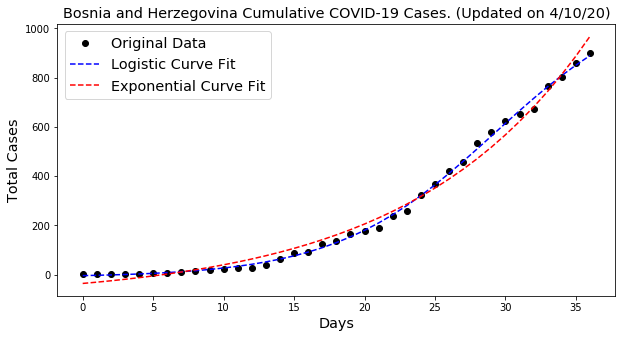



Cameroon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 820
	Confirmed cases on 4/3/20 	 509
	Ratio: 1.61
	Weekly increase: 61.1 %
	Daily increase: 7.0 % per day
	Doubling Time (represents recent growth): 10.2 days

** Based on Logistic Fit**

	R^2: 0.9891237370105915
	Doubling Time (during middle of growth):  3.28 (± 0.56 ) days
	param:  [1.18637041e+05 4.23164986e-01 1.53676111e+01 8.13581912e+02]

** Based on Exponential Fit **

	R^2: 0.9531299790918796
	Doubling Time (represents overall growth):  6.0 (± 1.17 ) days
	param:  [ 16.96901929   0.11545958 -49.94735692]


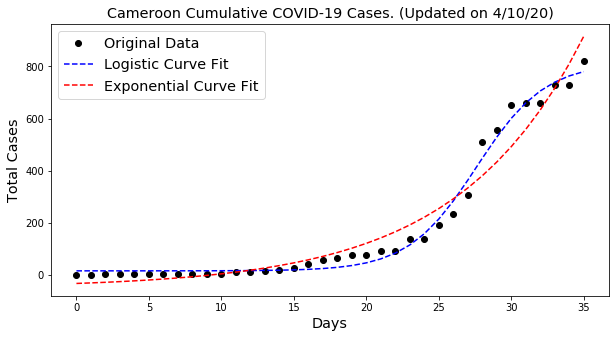



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 812
	Confirmed cases on 4/3/20 	 464
	Ratio: 1.75
	Weekly increase: 75.0 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9962423577726274
	Doubling Time (during middle of growth):  6.24 (± 0.86 ) days
	param:  [ 1.05958708e+02  2.22157474e-01 -3.42179036e+00  9.79555756e+02]

** Based on Exponential Fit **

	R^2: 0.9819942761487009
	Doubling Time (represents overall growth):  7.97 (± 1.48 ) days
	param:  [ 8.69924963e+01  8.70188134e-02 -1.00000000e+02]




Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 715
	Confirmed cases on 4/3/20 	 450
	Ratio: 1.59
	Weekly increase: 58.9 %
	Daily increase: 6.8 % per day
	Doubling Time (represents recent growth): 10.5 days

** Based on Logistic Fit**

	R^2: 0.9949993094870865
	Doubling Time (during middle of growth):  25.83 (± 19.92 ) days
	param:  [ 1.16151021e+06  5.36687349e-02 -1.53629128e+02  1.56369626e+08]

** Based on Exponential Fit **

	R^2: 0.9937505746623091
	Doubling Time (represents overall growth):  11.24 (± 1.2 ) days
	param:  [ 9.70757048e+01  6.16801809e-02 -1.00000000e+02]




Diamond Princess

** Based on Logistic Fit**

	R^2: 0.9963203863542578
	Doubling Time (during middle of growth):  2.82 (± 0.22 ) days
	param:  [8.97013674e+01 4.90932838e-01 6.86146843e+01 7.08719081e+02]

 exponential R^2  -0.6072384455066464




North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 711
	Confirmed cases on 4/3/20 	 430
	Ratio: 1.65
	Weekly increase: 65.3 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.6 days

** Based on Logistic Fit**

	R^2: 0.9970596491928804
	Doubling Time (during middle of growth):  8.67 (± 0.82 ) days
	param:  [ 4.27485966e+02  1.59815085e-01 -9.55414419e+00  9.68934676e+02]

** Based on Exponential Fit **

	R^2: 0.9876134832091327
	Doubling Time (represents overall growth):  8.59 (± 0.81 ) days
	param:  [ 23.33865366   0.08072675 -52.90260037]




Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 671
	Confirmed cases on 4/3/20 	 495
	Ratio: 1.36
	Weekly increase: 35.6 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 15.9 days

** Based on Logistic Fit**

	R^2: 0.9983904157956021
	Doubling Time (during middle of growth):  5.77 (± 0.37 ) days
	param:  [ 5.55821564e+02  2.40147064e-01 -1.64405525e+00  7.14560930e+02]

** Based on Exponential Fit **

	R^2: 0.967043671541419
	Doubling Time (represents overall growth):  9.93 (± 2.09 ) days
	param:  [ 6.58698028e+01  6.97701432e-02 -1.00000000e+02]


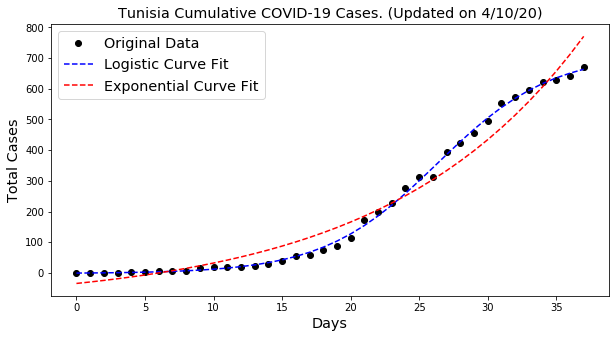



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 635
	Confirmed cases on 4/3/20 	 485
	Ratio: 1.31
	Weekly increase: 30.9 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.0 days

** Based on Logistic Fit**

	R^2: 0.9985755294900118
	Doubling Time (during middle of growth):  10.72 (± 1.14 ) days
	param:  [ 1.66345895e+01  1.29325174e-01 -5.93883603e+01  7.92999539e+02]

** Based on Exponential Fit **

	R^2: 0.9690433278812874
	Doubling Time (represents overall growth):  10.99 (± 2.82 ) days
	param:  [ 1.00000000e+02  6.30750448e-02 -7.74185285e+01]


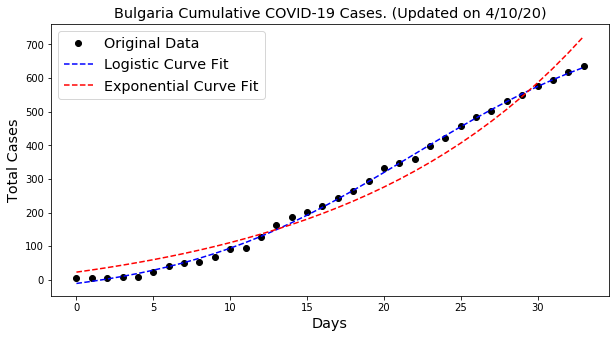



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 624
	Confirmed cases on 4/3/20 	 227
	Ratio: 2.75
	Weekly increase: 174.9 %
	Daily increase: 15.5 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9881232977292131
	Doubling Time (during middle of growth):  6.31 (± 1.85 ) days
	param:  [2.11251511e+02 2.19682766e-01 1.30632472e+01 1.09036864e+03]

** Based on Exponential Fit **

	R^2: 0.9842670076027108
	Doubling Time (represents overall growth):  5.51 (± 0.81 ) days
	param:  [ 26.56398187   0.12575424 -26.04395379]


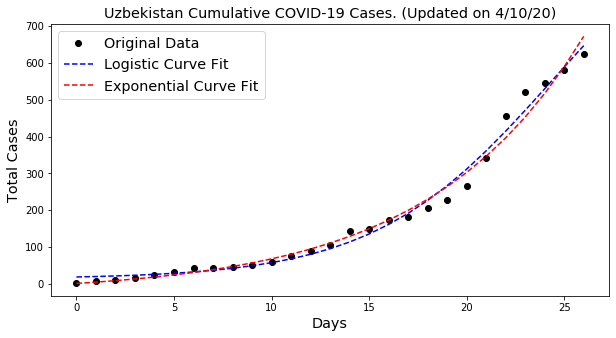



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 612
	Confirmed cases on 4/3/20 	 493
	Ratio: 1.24
	Weekly increase: 24.1 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.4 days

** Based on Logistic Fit**

	R^2: 0.9990991321533201
	Doubling Time (during middle of growth):  7.16 (± 0.35 ) days
	param:  [ 1.61064426e+02  1.93699422e-01 -1.00804606e+01  6.49969569e+02]

** Based on Exponential Fit **

	R^2: 0.9683864945998839
	Doubling Time (represents overall growth):  11.83 (± 2.63 ) days
	param:  [ 8.14081515e+01  5.86047271e-02 -1.00000000e+02]




Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 609
	Confirmed cases on 4/3/20 	 508
	Ratio: 1.2
	Weekly increase: 19.9 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 26.8 days

** Based on Logistic Fit**

	R^2: 0.9973761948628844
	Doubling Time (during middle of growth):  7.57 (± 0.53 ) days
	param:  [ 3.64472525e+02  1.83073301e-01 -4.41029628e-01  6.05399440e+02]

** Based on Exponential Fit **

	R^2: 0.958901713751521
	Doubling Time (represents overall growth):  14.83 (± 3.36 ) days
	param:  [ 8.05232067e+01  4.67372620e-02 -1.00000000e+02]


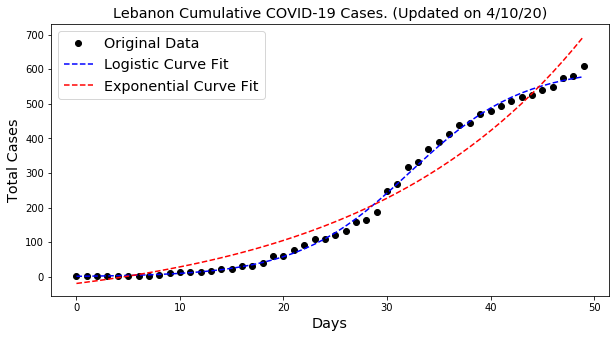



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 601
	Confirmed cases on 4/3/20 	 439
	Ratio: 1.37
	Weekly increase: 36.9 %
	Daily increase: 4.6 % per day
	Doubling Time (represents recent growth): 15.4 days

** Based on Logistic Fit**

	R^2: 0.9961746110467413
	Doubling Time (during middle of growth):  6.66 (± 0.66 ) days
	param:  [ 2.59449446e+02  2.08132914e-01 -1.33749940e+01  6.25095767e+02]

** Based on Exponential Fit **

	R^2: 0.9662379628695122
	Doubling Time (represents overall growth):  11.18 (± 2.45 ) days
	param:  [ 6.97205733e+01  6.19951050e-02 -1.00000000e+02]




Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 595
	Confirmed cases on 4/3/20 	 396
	Ratio: 1.5
	Weekly increase: 50.3 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 11.9 days

** Based on Logistic Fit**

	R^2: 0.996750084137604
	Doubling Time (during middle of growth):  8.72 (± 1.24 ) days
	param:  [ 6.30343922e+01  1.58897730e-01 -5.82546141e+00  8.25133848e+02]

** Based on Exponential Fit **

	R^2: 0.9911856988754049
	Doubling Time (represents overall growth):  10.34 (± 1.37 ) days
	param:  [ 8.50668828e+01  6.70224612e-02 -1.00000000e+02]




Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 564
	Confirmed cases on 4/3/20 	 269
	Ratio: 2.1
	Weekly increase: 109.7 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9964099492001821
	Doubling Time (during middle of growth):  9.91 (± 2.11 ) days
	param:  [ 1.02910878e+02  1.39953328e-01 -2.38420073e+01  1.59043897e+03]

** Based on Exponential Fit **

	R^2: 0.9955897705504265
	Doubling Time (represents overall growth):  6.68 (± 0.51 ) days
	param:  [ 30.37588907   0.10372435 -44.67570615]




Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 558
	Confirmed cases on 4/3/20 	 416
	Ratio: 1.34
	Weekly increase: 34.1 %
	Daily increase: 4.3 % per day
	Doubling Time (represents recent growth): 16.5 days

** Based on Logistic Fit**

	R^2: 0.9970041151968299
	Doubling Time (during middle of growth):  8.01 (± 0.86 ) days
	param:  [ 4.89503674e+01  1.73011051e-01 -1.82161354e+01  5.95028146e+02]

** Based on Exponential Fit **

	R^2: 0.971743910593339
	Doubling Time (represents overall growth):  12.25 (± 3.06 ) days
	param:  [ 9.88265900e+01  5.65606006e-02 -1.00000000e+02]


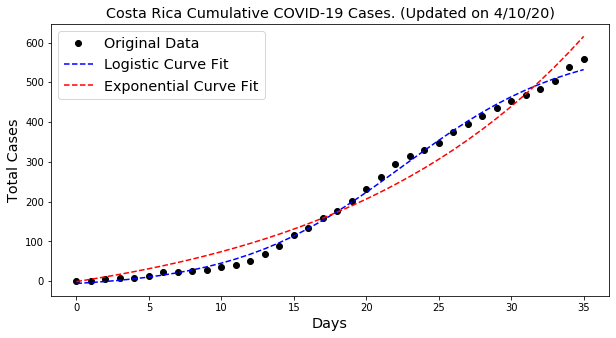



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 521
	Confirmed cases on 4/3/20 	 281
	Ratio: 1.85
	Weekly increase: 85.4 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9969054530703262
	Doubling Time (during middle of growth):  7.35 (± 0.66 ) days
	param:  [ 2.58646090e+03  1.88524235e-01 -1.15292447e-01  7.42290104e+02]

** Based on Exponential Fit **

	R^2: 0.988672848583193
	Doubling Time (represents overall growth):  6.54 (± 0.49 ) days
	param:  [  4.3883586    0.1059354  -16.26611139]


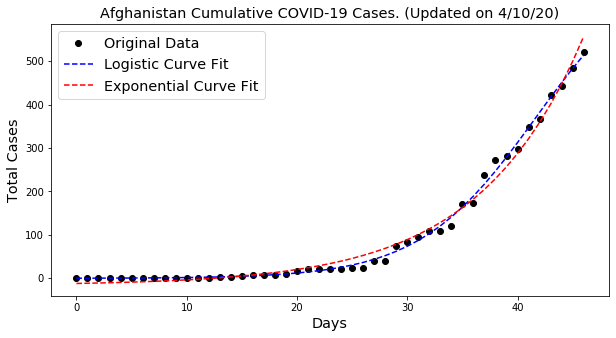



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 484
	Confirmed cases on 4/3/20 	 252
	Ratio: 1.92
	Weekly increase: 92.1 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9971348927908027
	Doubling Time (during middle of growth):  11.0 (± 1.23 ) days
	param:  [5.60210030e+02 1.26062374e-01 5.28354895e-01 1.30703861e+03]

** Based on Exponential Fit **

	R^2: 0.9959127049552019
	Doubling Time (represents overall growth):  7.12 (± 0.33 ) days
	param:  [ 5.77402635  0.09732119 -7.82157129]


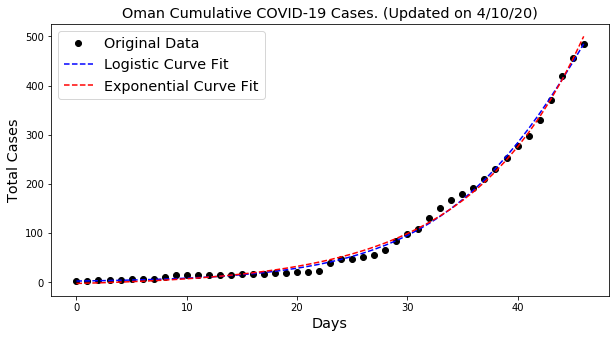



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 473
	Confirmed cases on 4/3/20 	 369
	Ratio: 1.28
	Weekly increase: 28.2 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.5 days

** Based on Logistic Fit**

	R^2: 0.9952238052870997
	Doubling Time (during middle of growth):  10.52 (± 2.84 ) days
	param:  [ 4.04153463e+00  1.31769928e-01 -1.42595728e+02  5.26001114e+02]

 exponential R^2  0.9062106921127933


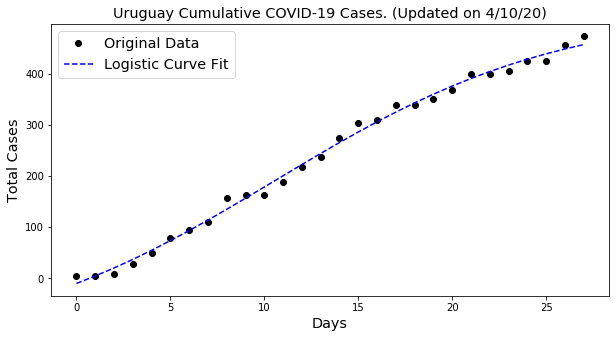



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 444
	Confirmed cases on 4/3/20 	 218
	Ratio: 2.04
	Weekly increase: 103.7 %
	Daily increase: 10.7 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9876313390724406
	Doubling Time (during middle of growth):  11.56 (± 5.13 ) days
	param:  [ 6.39516887e+01  1.19971071e-01 -3.37599291e+01  1.31015747e+03]

** Based on Exponential Fit **

	R^2: 0.9868698440589044
	Doubling Time (represents overall growth):  8.01 (± 1.16 ) days
	param:  [ 38.96642616   0.08649906 -56.94379143]


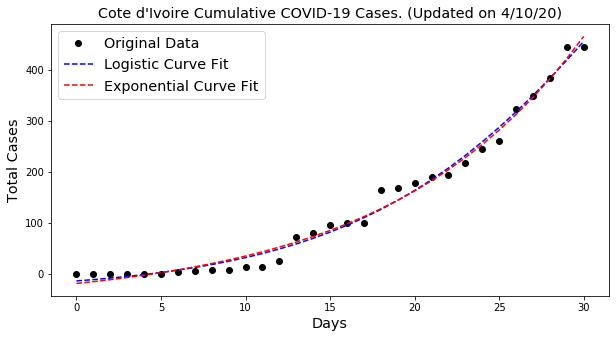



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 443
	Confirmed cases on 4/3/20 	 302
	Ratio: 1.47
	Weekly increase: 46.7 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.7 days

** Based on Logistic Fit**

	R^2: 0.9944324305769111
	Doubling Time (during middle of growth):  9.13 (± 1.78 ) days
	param:  [ 2.32576985e+01  1.51871070e-01 -3.77866774e+01  5.34612010e+02]

** Based on Exponential Fit **

	R^2: 0.9781521392776988
	Doubling Time (represents overall growth):  11.79 (± 2.93 ) days
	param:  [ 9.51058083e+01  5.88150607e-02 -1.00000000e+02]


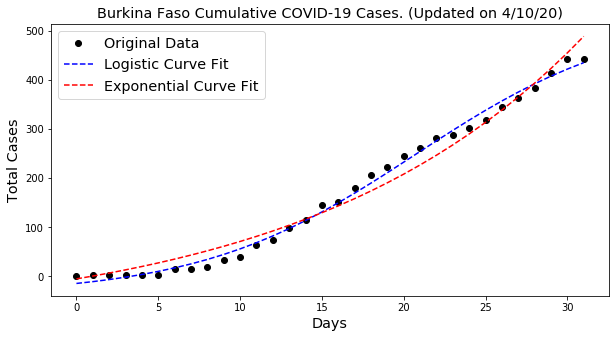



Niger

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 438
	Confirmed cases on 4/3/20 	 120
	Ratio: 3.65
	Weekly increase: 265.0 %
	Daily increase: 20.3 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9965914597989148
	Doubling Time (during middle of growth):  4.06 (± 0.62 ) days
	param:  [ 5.26283735e+02  3.41607646e-01 -1.98629585e+00  6.22808567e+02]

** Based on Exponential Fit **

	R^2: 0.9872004985252417
	Doubling Time (represents overall growth):  3.99 (± 0.55 ) days
	param:  [ 13.0354158    0.17366419 -27.62049725]




Bangladesh

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 424
	Confirmed cases on 4/3/20 	 61
	Ratio: 6.95
	Weekly increase: 595.1 %
	Daily increase: 31.9 % per day
	Doubling Time (represents recent growth): 2.5 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.976471005713351
	Doubling Time (represents overall growth):  2.15 (± 0.24 ) days
	param:  [9.47442308e-03 3.23072682e-01 1.96902271e+01]




Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 416
	Confirmed cases on 4/3/20 	 304
	Ratio: 1.37
	Weekly increase: 36.8 %
	Daily increase: 4.6 % per day
	Doubling Time (represents recent growth): 15.5 days

** Based on Logistic Fit**

	R^2: 0.9965754501304183
	Doubling Time (during middle of growth):  9.57 (± 1.48 ) days
	param:  [ 2.72162735e+01  1.44866765e-01 -8.00368377e+00  5.39973079e+02]

** Based on Exponential Fit **

	R^2: 0.9868671839211683
	Doubling Time (represents overall growth):  12.91 (± 2.52 ) days
	param:  [ 1.00000000e+02  5.37101035e-02 -9.40104210e+01]


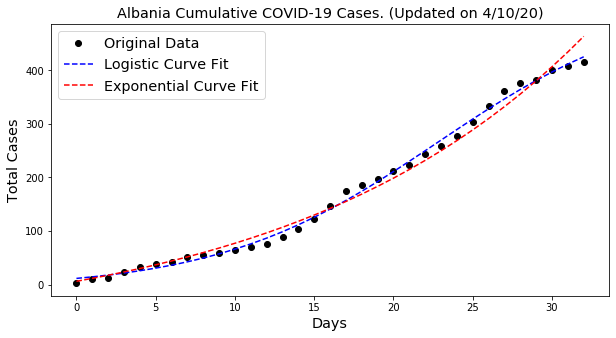



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 382
	Confirmed cases on 4/3/20 	 348
	Ratio: 1.1
	Weekly increase: 9.8 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 52.1 days

** Based on Logistic Fit**

	R^2: 0.9944911075780641
	Doubling Time (during middle of growth):  6.77 (± 0.53 ) days
	param:  [3.21198574e+05 2.04757754e-01 1.92622256e+01 3.93606379e+02]

** Based on Exponential Fit **

	R^2: 0.9529684518942569
	Doubling Time (represents overall growth):  13.32 (± 1.7 ) days
	param:  [  7.75933077   0.05204975 -12.84921125]




Honduras

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 382
	Confirmed cases on 4/3/20 	 222
	Ratio: 1.72
	Weekly increase: 72.1 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9950785906986501
	Doubling Time (during middle of growth):  5.58 (± 0.76 ) days
	param:  [ 2.46196426e+02  2.48631430e-01 -3.05514335e-01  4.09908528e+02]

** Based on Exponential Fit **

	R^2: 0.9776854287620806
	Doubling Time (represents overall growth):  8.69 (± 1.75 ) days
	param:  [ 42.20623871   0.07973579 -61.55289667]


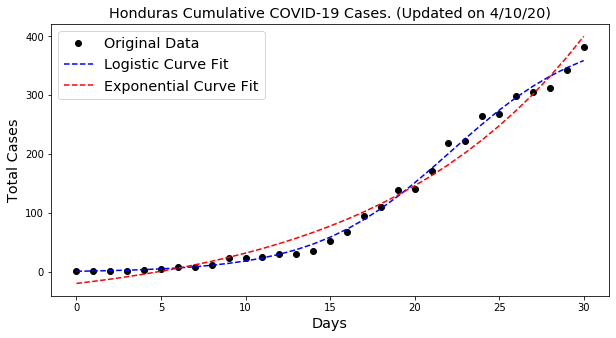



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 378
	Confirmed cases on 4/3/20 	 205
	Ratio: 1.84
	Weekly increase: 84.4 %
	Daily increase: 9.1 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9605953569346077
	Doubling Time (during middle of growth):  25.3 (± 51.75 ) days
	param:  [ 3.99797977e+06  5.47957096e-02 -1.23772532e+02  4.45955122e+08]

** Based on Exponential Fit **

	R^2: 0.960254598375642
	Doubling Time (represents overall growth):  11.49 (± 4.52 ) days
	param:  [ 9.22041531e+01  6.03129814e-02 -1.00000000e+02]




Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 372
	Confirmed cases on 4/3/20 	 310
	Ratio: 1.2
	Weekly increase: 20.0 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 26.6 days

** Based on Logistic Fit**

	R^2: 0.9949588995250412
	Doubling Time (during middle of growth):  6.12 (± 0.67 ) days
	param:  [ 1.58294105e+02  2.26497640e-01 -1.06240381e+01  3.71087917e+02]

 exponential R^2  0.9451121243713712


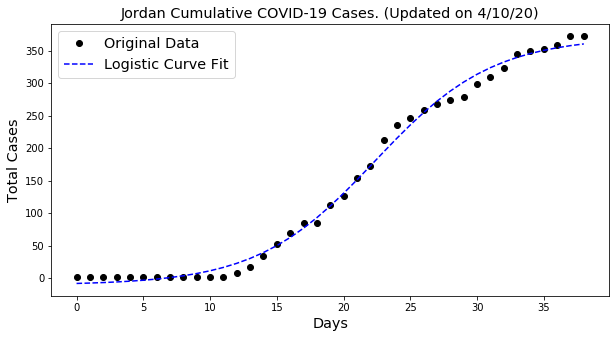



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 350
	Confirmed cases on 4/3/20 	 202
	Ratio: 1.73
	Weekly increase: 73.3 %
	Daily increase: 8.2 % per day
	Doubling Time (represents recent growth): 8.8 days

** Based on Logistic Fit**

	R^2: 0.9880065321057038
	Doubling Time (during middle of growth):  28.75 (± 24.03 ) days
	param:  [ 8.32002367e+06  4.82113628e-02 -9.16520111e+01  6.95963845e+08]

** Based on Exponential Fit **

	R^2: 0.9880065333082667
	Doubling Time (represents overall growth):  14.38 (± 2.69 ) days
	param:  [ 8.36492677e+01  4.82113523e-02 -9.16519977e+01]


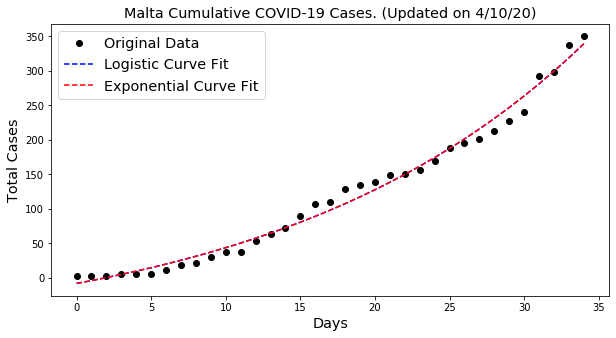



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 344
	Confirmed cases on 4/3/20 	 245
	Ratio: 1.4
	Weekly increase: 40.4 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.3 days

** Based on Logistic Fit**

	R^2: 0.9862404748604426
	Doubling Time (during middle of growth):  14.93 (± 4.64 ) days
	param:  [ 8.86887668e+00  9.28364737e-02 -5.19880554e+01  3.63756422e+02]

** Based on Exponential Fit **

	R^2: 0.9581043114452632
	Doubling Time (represents overall growth):  20.06 (± 7.02 ) days
	param:  [ 1.00000000e+02  3.45498683e-02 -8.97335055e+01]


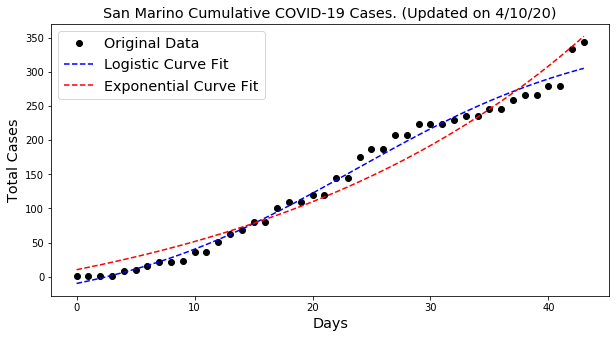



Mauritius

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 318
	Confirmed cases on 4/3/20 	 186
	Ratio: 1.71
	Weekly increase: 71.0 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9959411668804179
	Doubling Time (during middle of growth):  15.93 (± 10.91 ) days
	param:  [ 9.31089966e+00  8.70186432e-02 -9.57106849e+01  8.48331714e+02]

** Based on Exponential Fit **

	R^2: 0.9920668023982631
	Doubling Time (represents overall growth):  10.89 (± 2.25 ) days
	param:  [ 1.00000000e+02  6.36521312e-02 -9.54926048e+01]




Nigeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 305
	Confirmed cases on 4/3/20 	 210
	Ratio: 1.45
	Weekly increase: 45.2 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 13.0 days

** Based on Logistic Fit**

	R^2: 0.9975597889041572
	Doubling Time (during middle of growth):  5.98 (± 0.45 ) days
	param:  [ 2.17102170e+03  2.31890042e-01 -1.23843183e+00  3.31725184e+02]

** Based on Exponential Fit **

	R^2: 0.9738279507678134
	Doubling Time (represents overall growth):  8.1 (± 1.13 ) days
	param:  [  9.92746855   0.08562109 -25.10102134]




Kyrgyzstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 298
	Confirmed cases on 4/3/20 	 130
	Ratio: 2.29
	Weekly increase: 129.2 %
	Daily increase: 12.6 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.9855480361460291
	Doubling Time (during middle of growth):  14.5 (± 14.62 ) days
	param:  [ 6.83290368e+06  9.55908800e-02 -3.67284503e+01  2.62011381e+08]

** Based on Exponential Fit **

	R^2: 0.9855480372002832
	Doubling Time (represents overall growth):  7.25 (± 1.43 ) days
	param:  [ 38.34558132   0.09559083 -36.72846559]


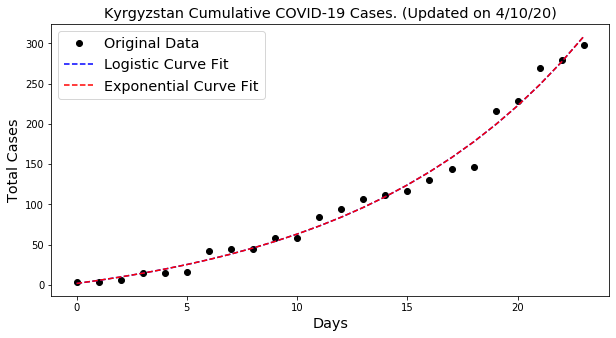



Bolivia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 268
	Confirmed cases on 4/3/20 	 132
	Ratio: 2.03
	Weekly increase: 103.0 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9909464496857688
	Doubling Time (during middle of growth):  12.17 (± 5.04 ) days
	param:  [ 9.69044767e+01  1.13884221e-01 -1.31016495e+01  1.16613135e+03]

** Based on Exponential Fit **

	R^2: 0.9906944171252201
	Doubling Time (represents overall growth):  7.41 (± 0.85 ) days
	param:  [ 17.73111472   0.09348159 -20.44568265]




West Bank and Gaza

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 267
	Confirmed cases on 4/3/20 	 194
	Ratio: 1.38
	Weekly increase: 37.6 %
	Daily increase: 4.7 % per day
	Doubling Time (represents recent growth): 15.2 days

** Based on Logistic Fit**

	R^2: 0.985820634143874
	Doubling Time (during middle of growth):  6.43 (± 1.37 ) days
	param:  [4.58543954e+02 2.15567850e-01 2.35211967e+01 3.33962574e+02]

** Based on Exponential Fit **

	R^2: 0.9715458314519104
	Doubling Time (represents overall growth):  9.0 (± 1.67 ) days
	param:  [ 19.84198644   0.0770161  -11.59572696]


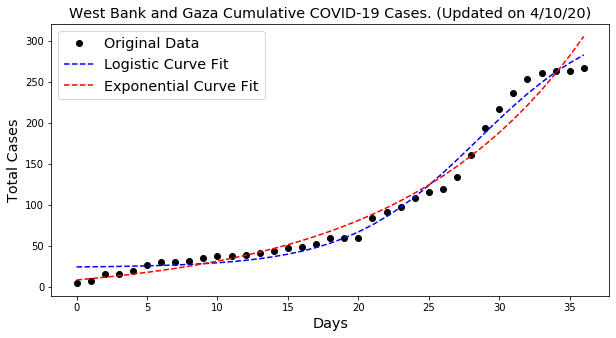



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 265
	Confirmed cases on 4/3/20 	 207
	Ratio: 1.28
	Weekly increase: 28.0 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.6 days

** Based on Logistic Fit**

	R^2: 0.9980498870973665
	Doubling Time (during middle of growth):  7.16 (± 0.52 ) days
	param:  [ 1.64191187e+02  1.93737674e-01 -1.81122289e+00  2.76957879e+02]

** Based on Exponential Fit **

	R^2: 0.974030520083881
	Doubling Time (represents overall growth):  15.26 (± 3.69 ) days
	param:  [ 6.29903876e+01  4.54175204e-02 -8.21182633e+01]




Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 257
	Confirmed cases on 4/3/20 	 237
	Ratio: 1.08
	Weekly increase: 8.4 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 59.9 days

** Based on Logistic Fit**

	R^2: 0.9970352950881386
	Doubling Time (during middle of growth):  8.35 (± 0.49 ) days
	param:  [2.89352683e+04 1.65943999e-01 1.01290778e+01 2.78652088e+02]

** Based on Exponential Fit **

	R^2: 0.9625837254079711
	Doubling Time (represents overall growth):  13.2 (± 1.51 ) days
	param:  [ 5.24945045  0.05252841 -9.10574802]


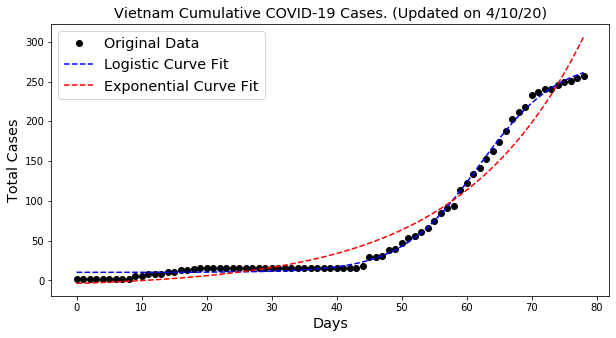



Montenegro

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 255
	Confirmed cases on 4/3/20 	 174
	Ratio: 1.47
	Weekly increase: 46.6 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.7 days

** Based on Logistic Fit**

	R^2: 0.988553417909426
	Doubling Time (during middle of growth):  6.83 (± 2.12 ) days
	param:  [ 2.63362104e+01  2.02975931e-01 -8.42878781e+00  3.23060637e+02]

** Based on Exponential Fit **

	R^2: 0.9772430838358771
	Doubling Time (represents overall growth):  11.99 (± 4.36 ) days
	param:  [ 9.71805590e+01  5.78110553e-02 -1.00000000e+02]




Kosovo

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 250
	Confirmed cases on 4/3/20 	 126
	Ratio: 1.98
	Weekly increase: 98.4 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

 logistic R^2  0.9472806755986352

 exponential R^2  0.9472806766646856




Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 234
	Confirmed cases on 4/3/20 	 155
	Ratio: 1.51
	Weekly increase: 51.0 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.8 days

** Based on Logistic Fit**

	R^2: 0.9967065602933983
	Doubling Time (during middle of growth):  16.96 (± 3.25 ) days
	param:  [ 1.16407880e+02  8.17571153e-02 -9.50961644e+00  1.02649651e+03]

** Based on Exponential Fit **

	R^2: 0.9964423586567445
	Doubling Time (represents overall growth):  10.32 (± 0.58 ) days
	param:  [ 13.37003143   0.06715064 -15.77768962]




Congo (Kinshasa)

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 215
	Confirmed cases on 4/3/20 	 134
	Ratio: 1.6
	Weekly increase: 60.4 %
	Daily increase: 7.0 % per day
	Doubling Time (represents recent growth): 10.3 days

** Based on Logistic Fit**

	R^2: 0.9913300757615479
	Doubling Time (during middle of growth):  7.9 (± 1.8 ) days
	param:  [ 5.05522839e+01  1.75500470e-01 -6.31420260e+00  2.56872506e+02]

** Based on Exponential Fit **

	R^2: 0.9832326037703928
	Doubling Time (represents overall growth):  11.85 (± 2.65 ) days
	param:  [ 47.56936092   0.05847744 -58.30135235]




Guinea

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 212
	Confirmed cases on 4/3/20 	 73
	Ratio: 2.9
	Weekly increase: 190.4 %
	Daily increase: 16.5 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9915245596885807
	Doubling Time (during middle of growth):  3.79 (± 0.68 ) days
	param:  [5.21610142e+03 3.65683654e-01 2.27530754e-01 2.42021305e+02]

** Based on Exponential Fit **

	R^2: 0.9737634628592641
	Doubling Time (represents overall growth):  4.39 (± 0.69 ) days
	param:  [ 2.85213536  0.15800324 -9.60640014]


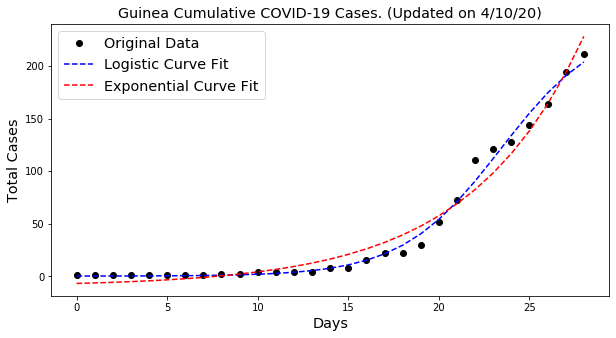



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 190
	Confirmed cases on 4/3/20 	 159
	Ratio: 1.19
	Weekly increase: 19.5 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.2 days

** Based on Logistic Fit**

	R^2: 0.9885810460589355
	Doubling Time (during middle of growth):  7.95 (± 0.94 ) days
	param:  [ 2.51800611e+04  1.74367830e-01 -1.27907686e+00  1.98148745e+02]

** Based on Exponential Fit **

	R^2: 0.9500181233273957
	Doubling Time (represents overall growth):  11.96 (± 1.6 ) days
	param:  [  3.28056005   0.05797894 -12.81793331]


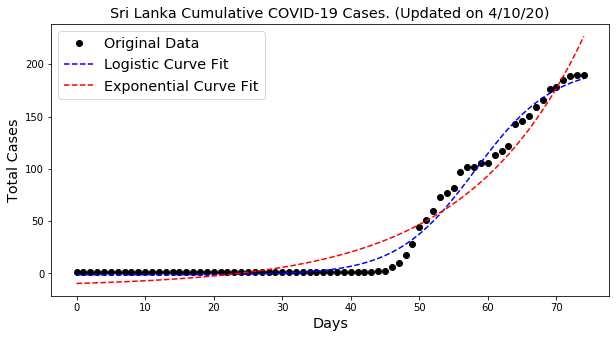



Kenya

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 189
	Confirmed cases on 4/3/20 	 122
	Ratio: 1.55
	Weekly increase: 54.9 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.994066891780167
	Doubling Time (during middle of growth):  4.76 (± 0.72 ) days
	param:  [4.07003619e+02 2.91188026e-01 3.80681524e+00 2.14202481e+02]

** Based on Exponential Fit **

	R^2: 0.9728165762796221
	Doubling Time (represents overall growth):  8.15 (± 1.88 ) days
	param:  [ 22.59165895   0.08505597 -31.40981822]


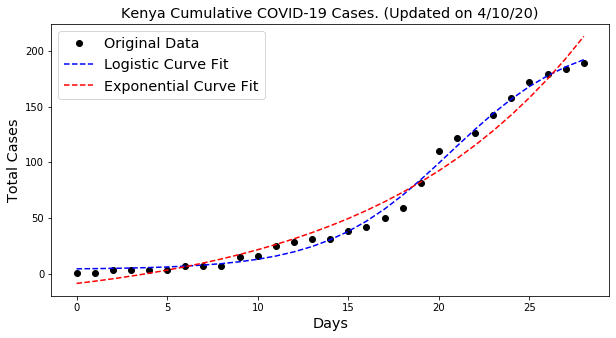



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 171
	Confirmed cases on 4/3/20 	 153
	Ratio: 1.12
	Weekly increase: 11.8 %
	Daily increase: 1.6 % per day
	Doubling Time (represents recent growth): 43.6 days

** Based on Logistic Fit**

	R^2: 0.995665172460979
	Doubling Time (during middle of growth):  10.21 (± 2.56 ) days
	param:  [ 2.56411483e+00  1.35766035e-01 -6.86301671e+01  1.88526345e+02]

 exponential R^2  0.9118467771649746


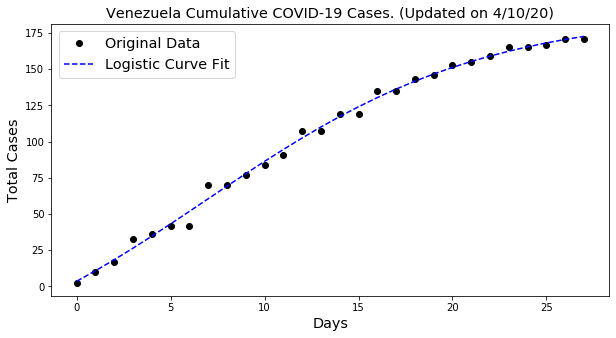



Djibouti

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 150
	Confirmed cases on 4/3/20 	 49
	Ratio: 3.06
	Weekly increase: 206.1 %
	Daily increase: 17.3 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9851117415074814
	Doubling Time (during middle of growth):  5.89 (± 2.24 ) days
	param:  [2.69143572e+02 2.35298553e-01 1.64465820e-01 3.41156358e+02]

** Based on Exponential Fit **

	R^2: 0.9831173558055243
	Doubling Time (represents overall growth):  4.31 (± 0.65 ) days
	param:  [ 4.06054484  0.16096662 -5.3276464 ]




Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 136
	Confirmed cases on 4/3/20 	 134
	Ratio: 1.01
	Weekly increase: 1.5 %
	Daily increase: 0.2 % per day
	Doubling Time (represents recent growth): 327.5 days

** Based on Logistic Fit**

	R^2: 0.993171332206145
	Doubling Time (during middle of growth):  9.28 (± 2.04 ) days
	param:  [  2.11791321   0.14934484 -69.93338646 142.36025268]

 exponential R^2  0.8294339240681187


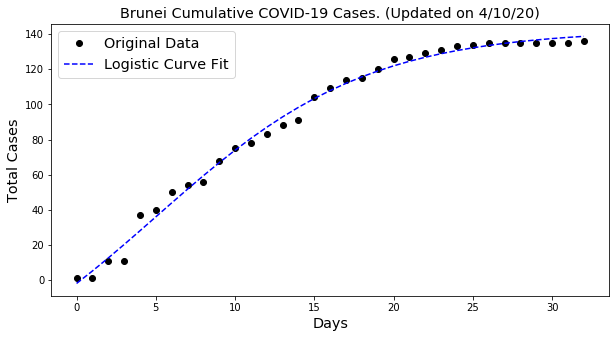



Paraguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 129
	Confirmed cases on 4/3/20 	 92
	Ratio: 1.4
	Weekly increase: 40.2 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.4 days

** Based on Logistic Fit**

	R^2: 0.9952065881549844
	Doubling Time (during middle of growth):  8.33 (± 1.29 ) days
	param:  [ 59.33982083   0.16649954  -1.82458858 161.17899524]

** Based on Exponential Fit **

	R^2: 0.985369314914762
	Doubling Time (represents overall growth):  12.43 (± 2.37 ) days
	param:  [ 27.22493587   0.05578372 -32.46081209]




Guatemala

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 126
	Confirmed cases on 4/3/20 	 50
	Ratio: 2.52
	Weekly increase: 152.0 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.9789944833218509
	Doubling Time (during middle of growth):  13.33 (± 2.24 ) days
	param:  [ 3.53592294e+08  1.04005265e-01 -1.40269799e+00  2.41781135e+09]

** Based on Exponential Fit **

	R^2: 0.9789944839108314
	Doubling Time (represents overall growth):  6.66 (± 1.22 ) days
	param:  [ 6.83790688  0.10400497 -1.40279418]


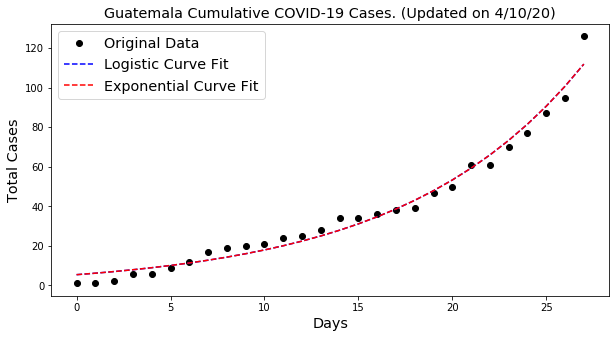



Cambodia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 119
	Confirmed cases on 4/3/20 	 114
	Ratio: 1.04
	Weekly increase: 4.4 %
	Daily increase: 0.6 % per day
	Doubling Time (represents recent growth): 113.0 days

** Based on Logistic Fit**

	R^2: 0.9950028786386523
	Doubling Time (during middle of growth):  3.58 (± 0.33 ) days
	param:  [1.02806451e+09 3.87434014e-01 7.22206505e-01 1.12935287e+02]

 exponential R^2  0.8838037322259643


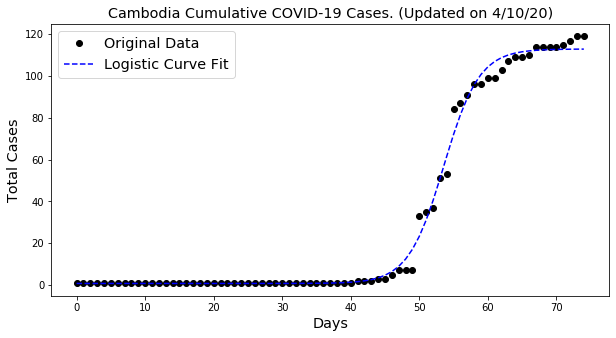



Rwanda

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 118
	Confirmed cases on 4/3/20 	 89
	Ratio: 1.33
	Weekly increase: 32.6 %
	Daily increase: 4.1 % per day
	Doubling Time (represents recent growth): 17.2 days

** Based on Logistic Fit**

	R^2: 0.9940830118822719
	Doubling Time (during middle of growth):  7.9 (± 1.67 ) days
	param:  [ 10.72560823   0.17540803 -13.04130252 126.69152665]

** Based on Exponential Fit **

	R^2: 0.9721641291381734
	Doubling Time (represents overall growth):  22.61 (± 13.93 ) days
	param:  [ 1.00000000e+02  3.06584310e-02 -9.92361361e+01]


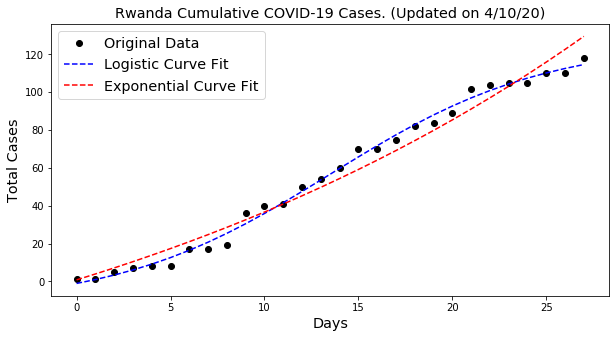



El Salvador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 117
	Confirmed cases on 4/3/20 	 46
	Ratio: 2.54
	Weekly increase: 154.3 %
	Daily increase: 14.3 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.9972831541580766
	Doubling Time (during middle of growth):  12.45 (± 5.08 ) days
	param:  [ 1.08564320e+07  1.11319465e-01 -1.19034898e+01  1.20636480e+08]

** Based on Exponential Fit **

	R^2: 0.9972831544298986
	Doubling Time (represents overall growth):  6.23 (± 0.5 ) days
	param:  [ 11.11199788   0.11131938 -11.90350474]


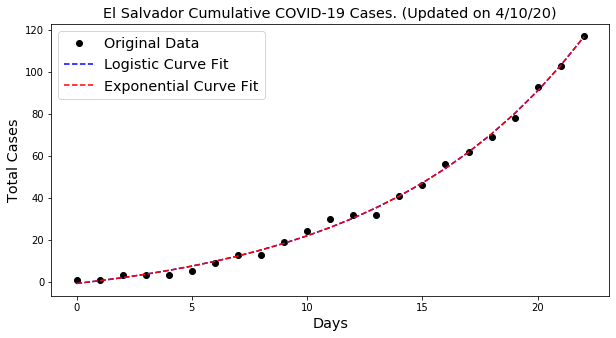



Trinidad and Tobago

** Based on Most Recent Week of Data **

	Confirmed cases on 4/10/20 	 109
	Confirmed cases on 4/3/20 	 98
	Ratio: 1.11
	Weekly increase: 11.2 %
	Daily increase: 1.5 % per day
	Doubling Time (represents recent growth): 45.6 days

** Based on Logistic Fit**

	R^2: 0.9747449119977136
	Doubling Time (during middle of growth):  7.53 (± 3.24 ) days
	param:  [  4.70229698   0.18414424 -30.01414417 113.41558161]

 exponential R^2  0.8931423140726525


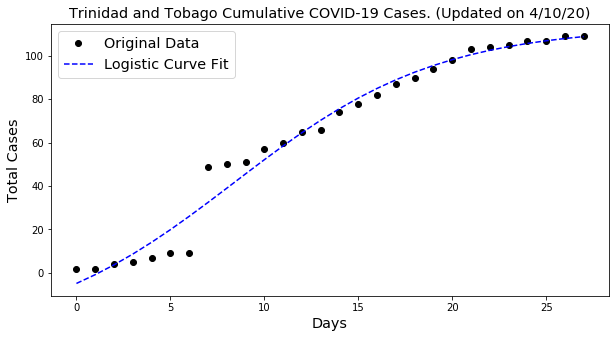

In [6]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

cnames = topcountries.values

for c in cnames:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


     Inferred Doubling Time  95%CI  Recent Doubling Time
0                       6.7    0.2                   8.2
1                       7.0    0.2                  17.1
2                       9.0    0.3                  23.3
3                       8.7    0.6                   7.4
4                       7.5    0.2                  16.6
5                       6.6    0.5                 933.5
6                       7.6    0.3                   7.4
7                      14.3    1.5                  19.5
8                       6.8    0.7                   6.0
9                       7.3    0.3                  10.5
10                      7.6    0.5                  21.6
11                      8.4    0.4                  12.6
12                      6.9    0.2                 

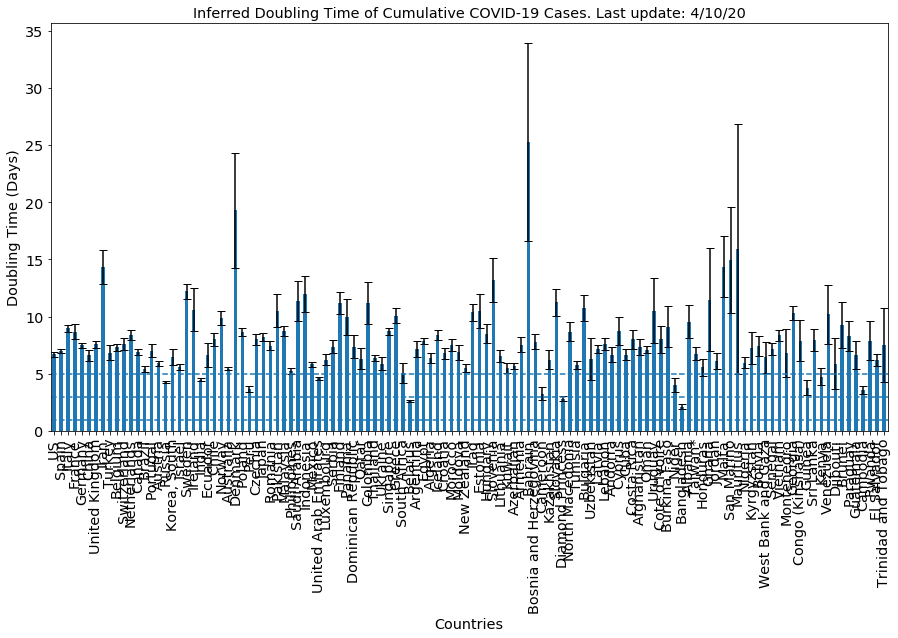

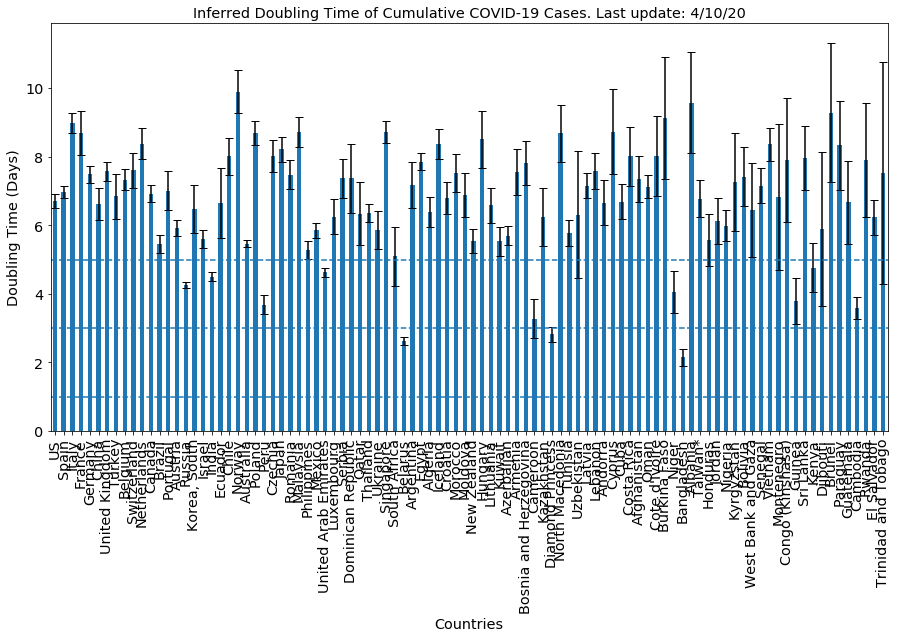

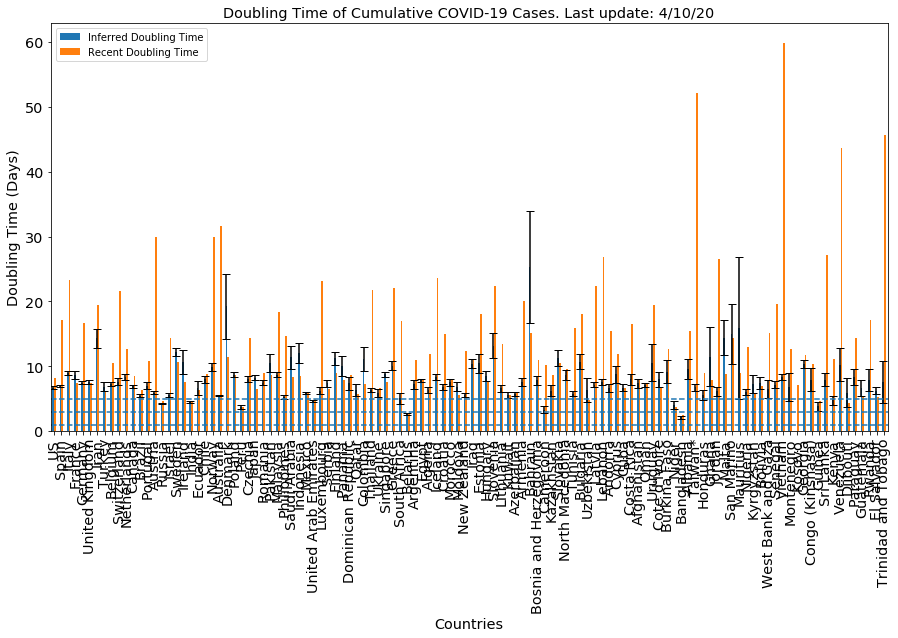

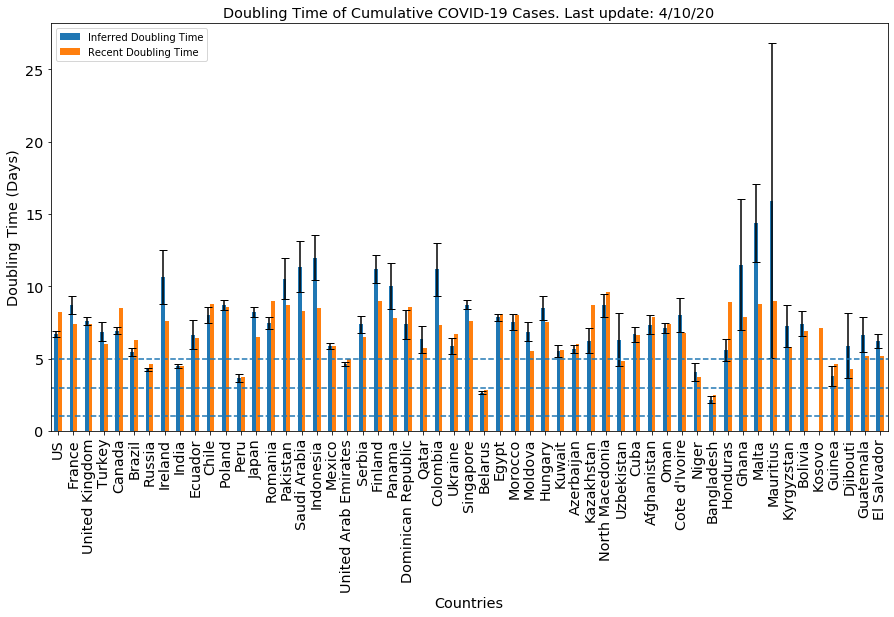

In [7]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()